# Analisis E-commerce OLIST

Data yang digunakan dalam analisis ini berasal dari platform e-commerce asal Brasil, yaitu **OLIST**. Dataset ini berisi informasi mengenai transaksi antara pelanggan dan penjual, termasuk rincian pembelian, pengiriman, pembayaran, dan ulasan pelanggan. Dataset mencakup **40 kolom** dan **119.143 baris**, dengan periode waktu transaksi mulai dari **tahun 2016 hingga 2018**.

## Tujuan Analisis:
Analisis ini bertujuan untuk:

- Menggambarkan **distribusi demografis dan lokasi pelanggan**
- Menganalisis **waktu transaksi**, **kategori produk**, dan **metode pembayaran**
- Mengidentifikasi **pola dan tren pembelian**, serta peluang pengembangan bisnis
- Mengukur **tingkat kepuasan pelanggan** berdasarkan ulasan dan skor
- Melakukan **analisis deret waktu (time series)** dan **analisis perilaku pembelian**
- Memberikan **rekomendasi berbasis data** kepada tim bisnis OLIST

Analisis dilakukan menggunakan bahasa pemrograman **Python** dengan library seperti `pandas`, `matplotlib`, dan `seaborn`, serta melibatkan proses **pengambilan data dari SQL**, penggabungan tabel, **pembersihan data**, **transformasi waktu**, dan **visualisasi data**. Seluruh proses ini menjadi landasan untuk menghasilkan insight yang dapat membantu pengambilan keputusan bisnis secara lebih strategis.


# Import dataset via SQL query file and connect SQL with Python

In [1]:
# Import library untuk SQLite
import sqlite3

In [2]:
# Hubungkan ke database SQLite (sesui letak dimana data disimpan)
conn = sqlite3.connect(r"D:\Growia\Modul 9\Beginner Level\foo.db")

In [3]:
# Buat cursor untuk menjalankan perintah SQL
cursor = conn.cursor()

In [4]:
# Eksekusi query untuk mendapatkan daftar tabel dalam database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

In [5]:
# Ambil hasil query dan tampilkan nama tabel yang ada
tables = cursor.fetchall()
print("Tables:", tables)

Tables: [('olist_customers_dataset',), ('olist_geolocation_dataset',), ('olist_orders_dataset',), ('olist_order_items_dataset',), ('olist_order_payments_dataset',), ('olist_order_reviews_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('product_category_name_translation',)]


# Import library ( pandas, numpy, matplotlib, and seaborn)

In [6]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the datasets using key columns based on the dataset structure

# Struktur Dataset OLIST

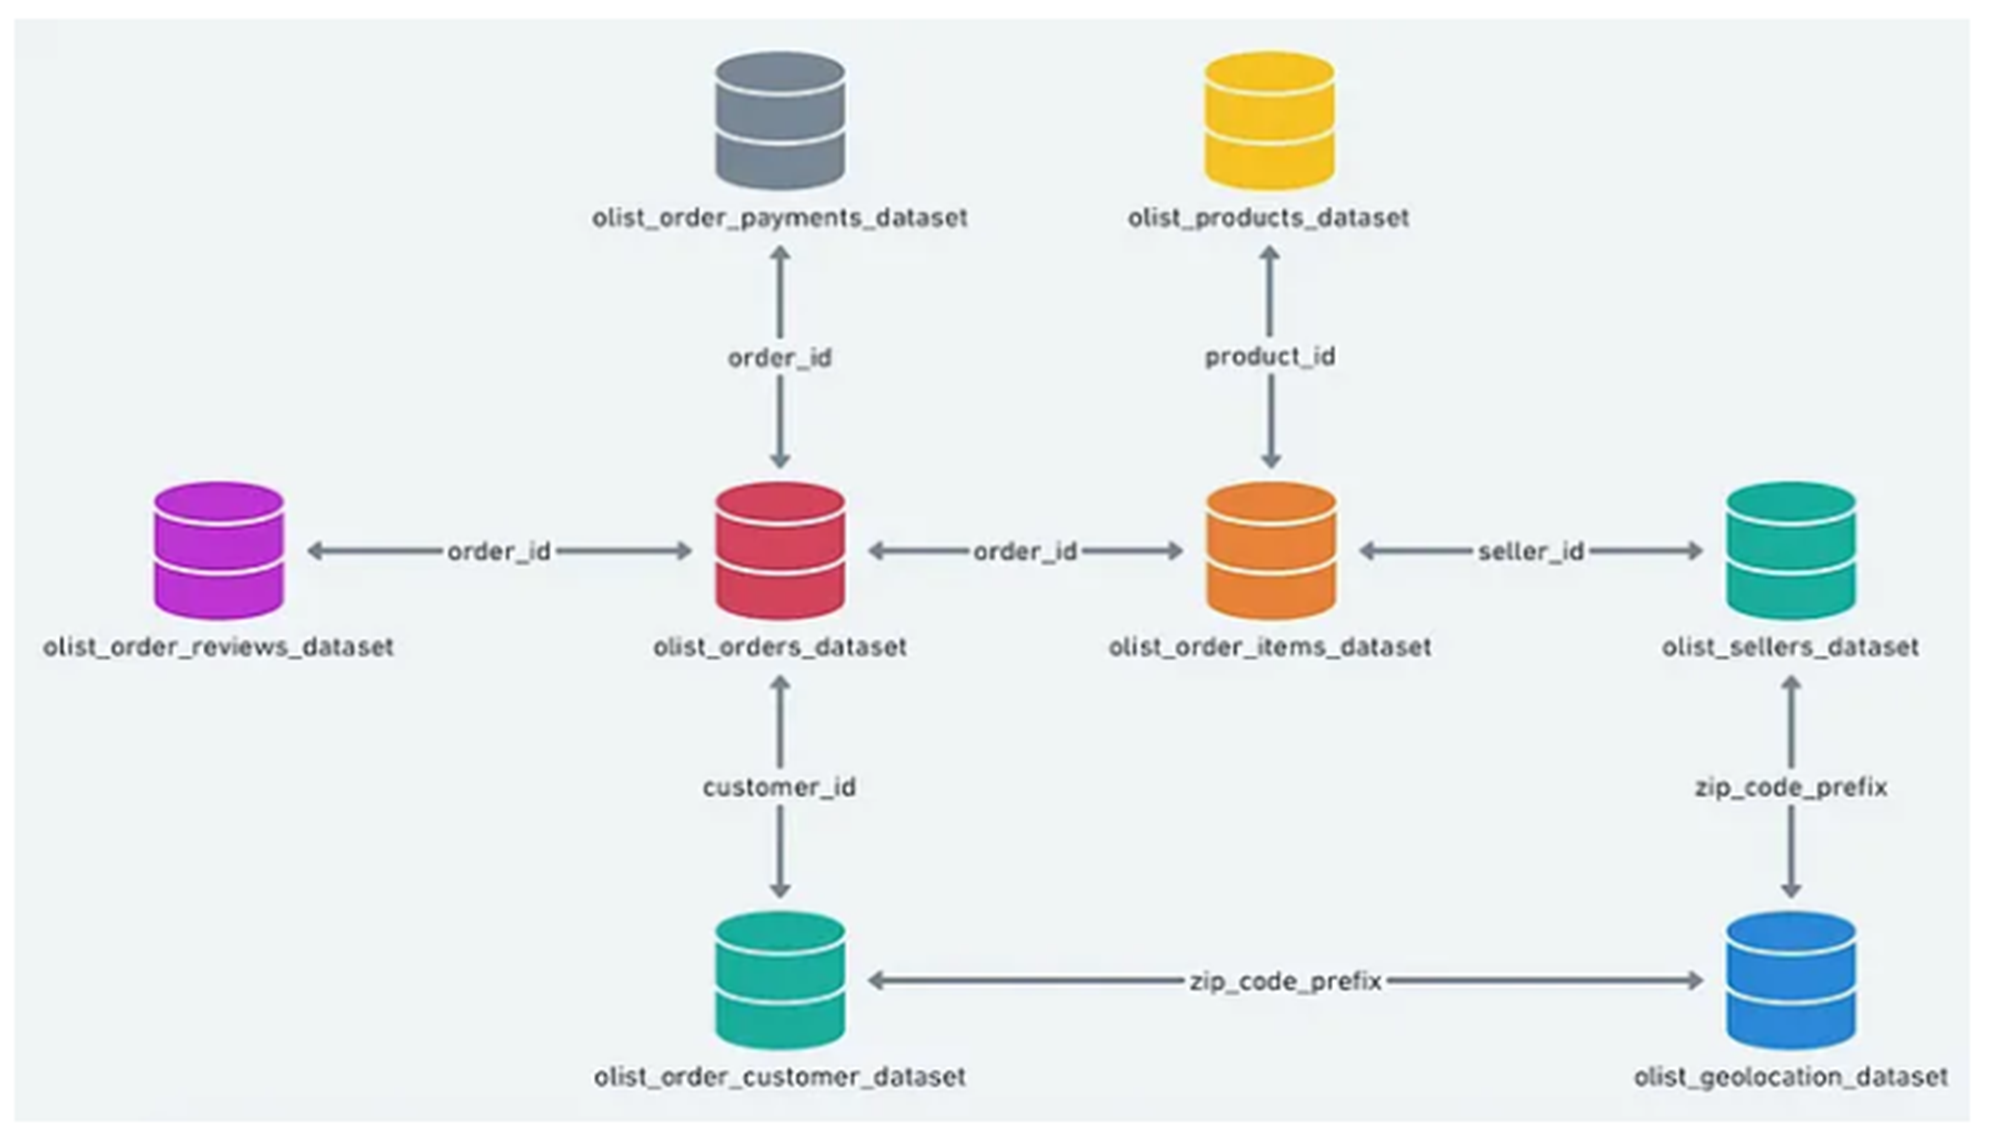

In [7]:
# Load dataset dari database SQLite 
# Tujuannya untuk mengambil data yang tersimpan di dalam database agar bisa dianalisis atau diolah lebih lanjut menggunakan Python
df_orders = pd.read_sql("SELECT * FROM olist_orders_dataset", conn)
df_order_items = pd.read_sql("SELECT * FROM olist_order_items_dataset", conn)
df_customers = pd.read_sql("SELECT * FROM olist_customers_dataset", conn)
df_sellers = pd.read_sql("SELECT * FROM olist_sellers_dataset", conn)
df_products = pd.read_sql("SELECT * FROM olist_products_dataset", conn)
df_order_payments = pd.read_sql("SELECT * FROM olist_order_payments_dataset", conn)
df_order_reviews = pd.read_sql("SELECT * FROM olist_order_reviews_dataset", conn)
df_geolocation = pd.read_sql("SELECT * FROM olist_geolocation_dataset", conn)
df_product_category_name_translation = pd.read_sql("SELECT * FROM product_category_name_translation", conn)

In [8]:
# Cek kolom dari setiap tabel
tables = {
    "orders": df_orders,
    "order_items": df_order_items,
    "customers": df_customers,
    "sellers": df_sellers,
    "products": df_products,
    "order_payments": df_order_payments,
    "order_reviews": df_order_reviews,
    "geolocation": df_geolocation,
    "product_category_name_translation": df_product_category_name_translation
}

In [9]:
for table_name, df in tables.items():
    print(f"Tabel '{table_name}' memiliki kolom-kolom berikut:")
    print(df.columns.tolist())
    print("-" * 50)

Tabel 'orders' memiliki kolom-kolom berikut:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
--------------------------------------------------
Tabel 'order_items' memiliki kolom-kolom berikut:
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
--------------------------------------------------
Tabel 'customers' memiliki kolom-kolom berikut:
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
--------------------------------------------------
Tabel 'sellers' memiliki kolom-kolom berikut:
['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']
--------------------------------------------------
Tabel 'products' memiliki kolom-kolom berikut:
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght'

Diketahui penulisan kolom 'product_category_name' mengandung Hidden Special Character atau  Byte Order Mark (BOM), sehingga untuk melakukan join ke data terkait (df_product_category_name_translation) harus di rename untuk menghilangkan karakter tersebut.

In [10]:
# Rename the column in df_product_category_name_translation
df_product_category_name_translation = df_product_category_name_translation.rename(columns={'﻿product_category_name': 'product_category_name'})

##### Gunakan tabel df_orders sebagai key connection utama atau tabel pusat karena tabel orders adalah inti dari keseluruhan transaksi di dataset OLIST.

Semua tabel lainnya “berkaitan” dengan orders
- customers: butuh customer_id → ini ada di orders

- order_items: mencatat barang yang dibeli per order_id

- products: berkaitan via product_id dari order_items

- product_category_name_translation : terkait dengan product_category_name

- sellers: terkait melalui seller_id dari order_items

- order_payments: detail pembayaran per order_id

- order_reviews: review tiap order_id

    - Jadi, semua berkiblat ke order_id sebagai penghubung utama, dan orders adalah satu-satunya tabel yang punya semua ID kunci itu.


how='left' memastikan semua data dari df_orders tetap ada, meskipun tidak ada pasangan di tabel lain.

Ini setara dengan LEFT JOIN di SQL seperti pada query yang kamu buat sebelumnya.

In [11]:
df = (
    df_orders  # Data utama: informasi pesanan
    .merge(df_customers, on='customer_id', how='left')  # Gabungkan dengan customers
    .merge(df_order_items, on='order_id', how='left')  # Gabungkan dengan order_items
    .merge(df_products, on='product_id', how='left')  # Gabungkan dengan products
    .merge(df_product_category_name_translation, on='product_category_name', how='left')  # Gabungkan dengan product_category_name_translation
    .merge(df_sellers, on='seller_id', how='left')  # Gabungkan dengan sellers
    .merge(df_order_payments, on='order_id', how='left')  # Gabungkan dengan order_payments
    .merge(df_order_reviews, on='order_id', how='left')  # Gabungkan dengan order_reviews
)

In [12]:
# Cek hasil
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,1,boleto,1,141.46,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1,credit_card,3,179.12,e73b67b67587f7644d5bd1a52deb1b01,5,,,2018-08-18 00:00:00,2018-08-22 19:07:58


# Deal Null Values

## Data Cleaning

In [13]:
# Cek kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   order_id                       119143 non-null  object
 1   customer_id                    119143 non-null  object
 2   order_status                   119143 non-null  object
 3   order_purchase_timestamp       119143 non-null  object
 4   order_approved_at              119143 non-null  object
 5   order_delivered_carrier_date   119143 non-null  object
 6   order_delivered_customer_date  119143 non-null  object
 7   order_estimated_delivery_date  119143 non-null  object
 8   customer_unique_id             119143 non-null  object
 9   customer_zip_code_prefix       119143 non-null  object
 10  customer_city                  119143 non-null  object
 11  customer_state                 119143 non-null  object
 12  order_item_id                  118310 non-nu

- Total Kolom ada 40 kolom dan 119143 baris, hapus kolom yang kurang diperlukan pada analisa ini

In [14]:
# Menghapus kolom-kolom yang dianggap tidak relevan untuk analisis lebih lanjut,
# seperti informasi dimensi produk, panjang nama/deskripsi produk, kode pos pelanggan,
# serta timestamp dan tanggal pembuatan ulasan.
# Tujuannya adalah menyederhanakan dataset agar lebih fokus pada variabel penting saja.
df = df.drop(columns=['product_photos_qty', 'product_name_lenght', 'product_description_lenght',
                      'product_length_cm', 'product_width_cm', 'product_height_cm',
                      'customer_zip_code_prefix', 'review_answer_timestamp',
                      'review_creation_date'])

- Sekarang tersisi hanya 31 kolom dan 119.143 baris
- Tipe data masih object semua, kita perlu mengkonversikan tiap kolomnya sesuai dengan tipenya masing-masing

In [15]:
# Konversi kolom tanggal ke format datetime
date_cols = [
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'shipping_limit_date'
]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # 'coerce' agar data invalid jadi NaT (null)

# Konversi kolom angka ke tipe numerik dengan aturan float & int
float_cols = ['price', 'freight_value', 'payment_value']
int_cols = [
    'product_weight_g', 'payment_sequential', 'payment_installments', 'review_score'
]
for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)  # Float

for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)  # Integer, NaN jadi 0

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              118966 non-null  datetime64[ns]
 5   order_delivered_carrier_date   117057 non-null  datetime64[ns]
 6   order_delivered_customer_date  115722 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119143 non-null  datetime64[ns]
 8   customer_unique_id             119143 non-null  object        
 9   customer_city                  119143 non-null  object        
 10  customer_state                 119143 non-null  object        
 11  

In [17]:
# Cek ringkasan statistik deskriptif dari dataset 
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
order_purchase_timestamp,119143,2017-12-29 18:36:13.115760128,2016-09-04 21:15:19,2017-09-10 20:15:46,2018-01-17 11:59:12,2018-05-03 13:18:30,2018-10-17 17:30:18,NaN
order_approved_at,118966,2017-12-30 04:49:18.425726976,2016-09-15 12:16:38,2017-09-11 15:50:48.500000,2018-01-17 16:49:49,2018-05-03 16:56:53,2018-09-03 17:40:06,NaN
order_delivered_carrier_date,117057,2018-01-03 08:24:34.395524864,2016-10-08 10:34:01,2017-09-14 19:52:12,2018-01-23 17:03:08,2018-05-07 14:57:00,2018-09-11 19:48:28,NaN
order_delivered_customer_date,115722,2018-01-12 20:55:38.199616,2016-10-11 13:46:32,2017-09-22 21:54:31.249999872,2018-02-01 03:17:55,2018-05-15 00:08:31.500000,2018-10-17 13:22:46,NaN
order_estimated_delivery_date,119143,2018-01-22 15:21:10.241642240,2016-09-30 00:00:00,2017-10-02 00:00:00,2018-02-14 00:00:00,2018-05-25 00:00:00,2018-11-12 00:00:00,NaN
shipping_limit_date,118310,2018-01-05 22:06:13.308807424,2016-09-19 00:15:34,2017-09-18 14:30:33,2018-01-25 04:11:15.500000,2018-05-10 02:51:40.249999872,2020-04-09 22:35:08,NaN
price,118310.0,120.646603,0.85,39.9,74.9,134.9,6735.0,184.109691
freight_value,118310.0,20.032387,0.0,13.08,16.28,21.18,409.68,15.83685
product_weight_g,119143.0,2097.128157,0.0,300.0,700.0,1800.0,40425.0,3777.315619
payment_sequential,119143.0,1.09471,0.0,1.0,1.0,1.0,29.0,0.730152


- Data transaksi dimulai dari 2016 hingga 2018, dengan beberapa anomali pada tanggal shipping limit yang sampai 2020.
- Ada beberapa data yang hilang, seperti order_approved_at, order_delivered_customer_date, dan payment_value.
- Dari data order_delivered_customer_date hanya 115722 data, artinya ini adalah data yang betul-betul sampai ke customer.

In [18]:
# Cek duplikasi data
df.duplicated().sum()

0

Secara keseluruhan tidak ada data yang duplikat 

In [19]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]  # Menampilkan hanya kolom yang ada missing value

order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_item_id                     833
product_id                        833
seller_id                         833
shipping_limit_date               833
price                             833
freight_value                     833
product_category_name             833
product_category_name_english    2567
seller_zip_code_prefix            833
seller_city                       833
seller_state                      833
payment_type                        3
payment_value                       3
review_id                         997
review_comment_title              997
review_comment_message            997
dtype: int64

Kesimpulan dari data yang missing value 
- Total kolom yang memiliki missing value: 19 kolom.
- order_delivered_customer_date (3.421 missing value) dan order_delivered_carrier_date (2.086 missing value)
- Kolom lain seperti: product_id, seller_id, price, review_id, dan review_comment_message juga memiliki 833–997 missing values.
- Banyak pesanan yang belum memiliki data pengiriman, kemungkinan karena keterlambatan atau pencatatan yang tidak lengkap.
- Ada pelanggan tidak memberikan ulasan atau komentar.
    - Bisa dilihat dari kolom seperti reviewid, review_comment_title,dan review_answer_message memiliki 997 missing values 
- Data transaksi produk dan seller memiliki beberapa kekosongan yang perlu diperiksa lebih lanjut

In [20]:
# Melihat daftar unik order_status
df['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Berikut arti dari setiap status dalam kolom order_status 
- delivered ---> Pesanan sudah sampai ke customer
- invoiced ---> Pesanan sudah dibuatkan invoice (tagihan), tapi belum dikirim
- shipped ---> Pesanan sudah dikirim oleh seller, dalam perjalanan ke customer
- processing ---> Pesanan sedang diproses oleh penjual, tapi belum dikirim
- unavailable ---> Barang tidak tersedia
- canceled ---> Pesanan dibatalkan, bisa oleh pembeli atau penjual
- created ---> Pesanan baru dibuat, tapi belum diproses lebih lanjut
- approved ---> Pesanan sudah disetujui, dan siap diproses lebih lanjut


In [21]:
# Melihat jumlah masing-masing status
df['order_status'].value_counts()

order_status
delivered      115723
shipped          1256
canceled          750
unavailable       652
invoiced          378
processing        376
created             5
approved            3
Name: count, dtype: int64

Dari data ini, data delivered (Pesanan sudah sampai ke customer) paling mendominasi, fokus saja pada item yang betul-betul sampai kepada customer

In [22]:
# Melihat data missing pada tabel order_item_id di kolom order_status 
df[df['order_item_id'].isnull()]['order_status'].value_counts()

order_status
unavailable    645
canceled       180
created          5
invoiced         2
shipped          1
Name: count, dtype: int64

- Artinya, 833 baris missing pada kolom tersebut semuanya berasal dari order yang statusnya bukan delivered. 
- Ini mengindikasikan bahwa:
- Order yang tidak selesai (seperti unavailable atau canceled) cenderung tidak memiliki data lengkap pada kolom order_item_id.
- Order delivered biasanya sudah mencapai tahap pemrosesan akhir sehingga memiliki informasi yang lengkap.

In [23]:
# Hanya mengambil data yang order_status delivered
df_delivered = df[df['order_status'] == 'delivered']

In [24]:
# Filter DataFrame agar hanya menyisakan baris dengan pesanan yang sudah dikirim dan diterima pelanggan
df = df[df['order_status'] == 'delivered']

In [25]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]  # Menampilkan hanya kolom yang ada missing value

order_approved_at                  15
order_delivered_carrier_date        2
order_delivered_customer_date       8
product_category_name_english    1661
payment_type                        3
payment_value                       3
review_id                         861
review_comment_title              861
review_comment_message            861
dtype: int64

- order_approved_at (15 missing)
Mungkin order diproses secara manual, ada keterlambatan pencatatan, atau terjadi kesalahan input.
- order_delivered_carrier_date (2 missing)
- order_delivered_customer_date (8 missing)
- product_category_name_english (1661 missing)
Mungkin data tidak tercatat dengan baik saat paket diserahkan ke kurir.
- Payment_type dan payment_value ada 3 juga yg kosong
- Kolom Review (review_id, review_comment_title, review_comment_message)
Terlihat 861 missing pada banyak kolom review. Pelanggan tidak memberikan review. Data review tidak tercatat meski pesanan berhasil.
- Ini adalah hal wajar, kadang banyak pembeli tapi tidak memberikan komentar

In [26]:
# Cek jumlah missing value tiap kolom dan berapa persentasenya
nan_col = df.isna().sum().sort_values(ascending=False)
nan_col

# Mendapatkan persentase missing value tiap kolom
n_data = len(df)

percent_nan_col = (nan_col / n_data) * 100
percent_nan_col

# Show count dan persen NaN
df_nan_col = pd.DataFrame({'count_nan': nan_col, 'persen_nan': percent_nan_col})
df_nan_col

,count_nan,persen_nan
product_category_name_english,1661,1.435324
review_comment_message,861,0.744018
review_id,861,0.744018
review_comment_title,861,0.744018
order_approved_at,15,0.012962
order_delivered_customer_date,8,0.006913
payment_type,3,0.002592
payment_value,3,0.002592
order_delivered_carrier_date,2,0.001728
product_category_name,0,0.000000


- Missing value masih dibawah 5 %, di drop saja

In [27]:
# Drop missing values
df = df.dropna()

# Check % apakah masih ada missing values
check_nan_col = df.isna().sum() / len(df) * 100
check_nan_col

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
customer_unique_id               0.0
customer_city                    0.0
customer_state                   0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
product_category_name            0.0
product_weight_g                 0.0
product_category_name_english    0.0
seller_zip_code_prefix           0.0
seller_city                      0.0
seller_state                     0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
r

In [28]:
# Analisis jumlah item yang dibeli dalam setiap pesanan (order) dan melihat distribusinya secara statistik
df.groupby('order_id')['order_item_id'].count().describe(percentiles=[0.5,0.8,0.9,0.95,0.99,0.999])

count    94466.000000
mean         1.198177
std          0.746111
min          1.000000
50%          1.000000
80%          1.000000
90%          2.000000
95%          2.000000
99%          4.000000
99.9%        8.000000
max         63.000000
Name: order_item_id, dtype: float64

- Dari data item yang delivered customer belanja min 1 kali, rata-rata customer belanja 1 kali dan jarang sekali berbelanja berkali-kali kecuali hanya sedikit sekali  

- Cek gambaran statistik data numerik yang berdasarkan data yang hanya order_status "delivered"

In [29]:
df.select_dtypes(include=['number']).describe()

,price,freight_value,product_weight_g,payment_sequential,payment_installments,payment_value,review_score
count,113187.000000,113187.000000,113187.000000,113187.000000,113187.000000,113187.000000,113187.000000
mean,119.864381,20.002989,2106.285837,1.090823,2.943774,171.576489,4.082615
std,181.163901,15.711971,3765.297605,0.686692,2.779316,264.257415,1.345828
min,0.850000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,39.900000,13.080000,300.000000,1.000000,1.000000,60.850000,4.000000
50%,74.900000,16.320000,700.000000,1.000000,2.000000,107.960000,5.000000
75%,132.980000,21.190000,1800.000000,1.000000,4.000000,189.160000,5.000000
max,6735.000000,409.680000,40425.000000,26.000000,24.000000,13664.080000,5.000000


- Ada data berat yang 0 ini tidak masuk akal

In [30]:
df[df['product_weight_g']==0].shape

(9, 31)

- Data yang berat 0 g hanya 9 baris, di exlude saja

In [31]:
# Filter dataframe Hanya ambil baris dengan berat produk lebih dari 0 gram
df = df[(df['product_weight_g'] > 0)] 

# Add Columns 

- Add columns based on the time period from the order purchase timestamp column

- Add columns by year

- Add columns by month

- Add columns by name of the day

- Add columns by hour

In [32]:
# Konversi kolom order_purchase_timestamp ke format datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Menambahkan kolom berdasarkan by year
df['year'] = df['order_purchase_timestamp'].dt.year
# Menambahkan kolom berdasarkan by month
df['month'] = df['order_purchase_timestamp'].dt.month
# Menambahkan kolom berdasarkan by day
df['day'] = df['order_purchase_timestamp'].dt.day_name()
# Menambahkan kolom berdasarkan by hour
df['hour'] = df['order_purchase_timestamp'].dt.hour
# Tambahkan kolom YearMonth dalam format 'YYYY-MM'
df['yearmonth'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)

In [33]:
# Cek hasil
df[['year','month','day','hour', 'yearmonth']].head()

,year,month,day,hour,yearmonth
0,2017,10,Monday,10,2017-10
1,2017,10,Monday,10,2017-10
2,2017,10,Monday,10,2017-10
3,2018,7,Tuesday,20,2018-07
4,2018,8,Wednesday,8,2018-08


- Add columns based on the actual price the customer purchased
   - Total price value
   - Total freight value
   - Total order value (total price + total freight)


In [34]:
# Menambahkan kolom Total Price Value
df['total_price_value'] = df['price']

# Menambahkan kolom Total Freight Value
df['total_freight_value'] = df['freight_value']

# Menambahkan kolom Total Order Value (Total Price + Total Freight)
df['total_order_value'] = df['price'] + df['freight_value']

In [35]:
# Cek hasil
df[['price', 'freight_value', 'total_price_value', 'total_freight_value', 'total_order_value']].head()

,price,freight_value,total_price_value,total_freight_value,total_order_value
0,29.99,8.72,29.99,8.72,38.71
1,29.99,8.72,29.99,8.72,38.71
2,29.99,8.72,29.99,8.72,38.71
3,118.70,22.76,118.70,22.76,141.46
4,159.90,19.22,159.90,19.22,179.12


# Exploratory Data Analysis
Exploratory data analysis (EDA) dilakukan untuk mengetahui, memahami, dan mempelajari data yang sudah disiapkan untuk memperoleh informasi atau insight yang penting

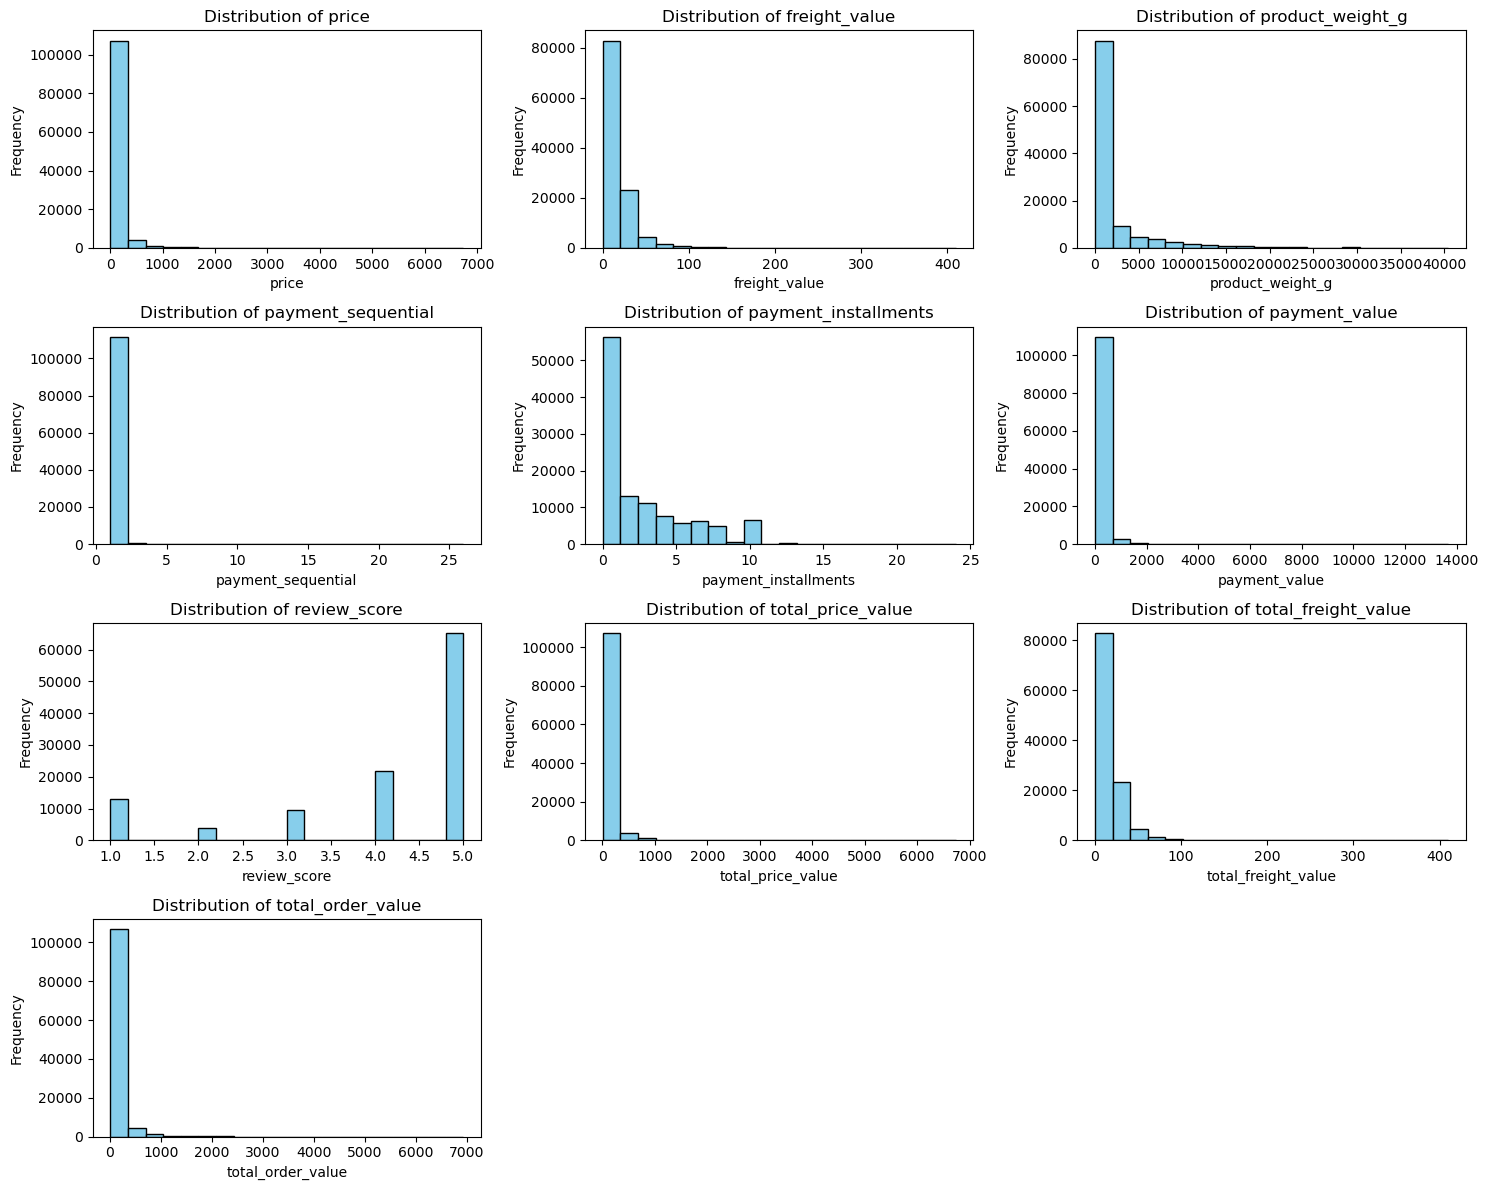

In [36]:
# Mengimpor modul math untuk menggunakan fungsi matematika, seperti pembulatan ke atas (ceil)
import math  

# Pilih kolom numerik dan buang yang terkait waktu
numerical_cols = df.select_dtypes(include=np.number).columns
excluded_cols = ['year', 'month', 'day_of_week', 'hour']
numerical_cols = [col for col in numerical_cols if col not in excluded_cols]

# Hitung jumlah baris dan kolom grid
num_cols = 3
num_rows = math.ceil(len(numerical_cols) / num_cols)

# Buat subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
axes = axes.flatten()

# Loop untuk buat histogram
for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Sembunyikan subplot kosong (jika ada)
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

# Atur layout dan tampilkan
plt.tight_layout()
plt.show()

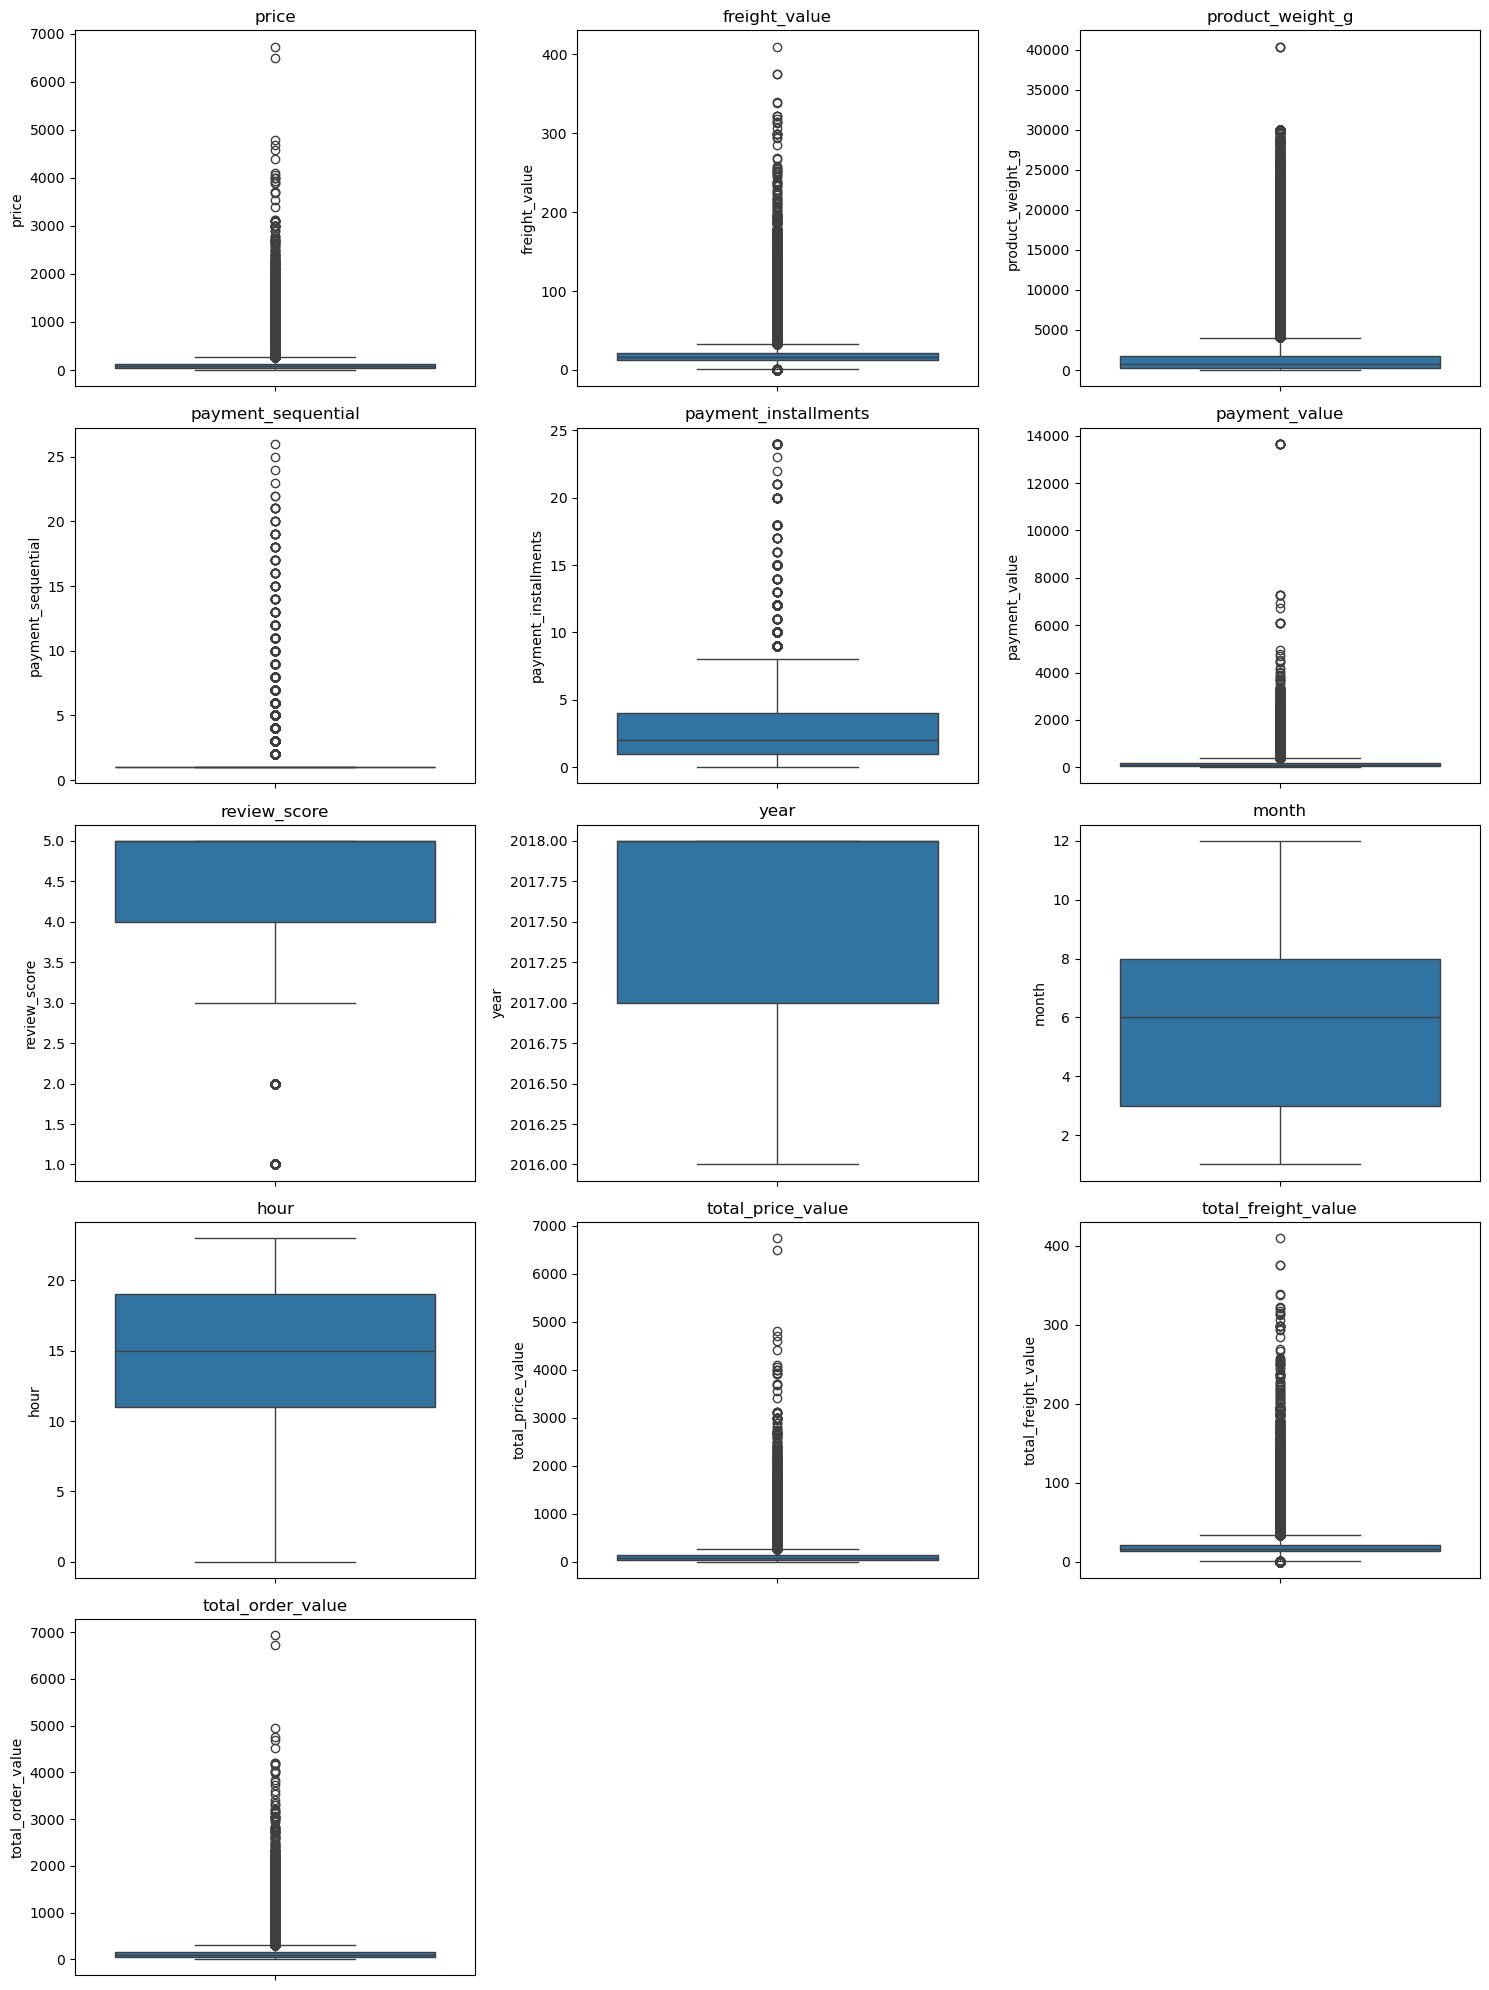

In [37]:
# Mengambil kolom-kolom bertipe numerik dari DataFrame
numerical_cols = df.select_dtypes(include=np.number).columns

# Menentukan jumlah baris dan kolom untuk grid visualisasi
num_cols_grid = 3  # Jumlah kolom dalam grid
num_rows = math.ceil(len(numerical_cols) / num_cols_grid)  # Menghitung jumlah baris yang dibutuhkan dengan pembulatan ke atas

# Membuat figure dan axes untuk grid subplot
fig, axes = plt.subplots(num_rows, num_cols_grid, figsize=(15, 4 * num_rows))

# Mengubah array axes menjadi satu dimensi untuk mempermudah iterasi
axes = axes.flatten()

# Melakukan iterasi pada setiap kolom numerik untuk membuat box plot
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i])  # Membuat box plot pada subplot saat ini
    axes[i].set_title(col)  # Menetapkan judul pada subplot
    axes[i].set_ylabel(col)  # Menetapkan label sumbu y

# Menyembunyikan subplot yang tidak digunakan
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

# Menyesuaikan tata letak agar tidak saling bertabrakan dan menampilkan plot
plt.tight_layout()
plt.show()

Visualisasi ini menunjukkan distribusi beberapa variabel utama dalam dataset, seperti harga produk, ongkos kirim, berat produk, nilai pembayaran, dan lain-lain. Mayoritas harga produk dan ongkir berada di kisaran rendah, yang menandakan dominasi produk dengan nilai transaksi kecil. Sebagian besar pembayaran dilakukan dalam satu kali cicilan, terlihat dari distribusi ‘payment_installments’ yang sangat tinggi di angka satu. Distribusi ini membantu kita memahami karakteristik umum transaksi dan dapat digunakan untuk menyusun strategi harga, promosi, serta opsi pembayaran yang lebih sesuai dengan perilaku customer.

# Customer Demographic
### Count Unique Customer Id by State
- Memberikan gambaran distribusi customer berdasarkan state (negara bagian) di Brazil.
- Mengidentifikasi state dengan jumlah customer terbanyak, yang kemungkinan merupakan pasar potensial utama.

In [38]:
# Mengganti nama kolom state dan city
df.rename(columns={'customer_state': 'address_static', 'customer_city': 'address_city'}, inplace=True)

In [39]:
df['address_city'].unique()

array(['sao paulo', 'barreiras', 'vianopolis', ..., 'messias targino',
       'campo do tenente', 'nova vicosa'], dtype=object)

In [40]:
# Menghitung jumlah unique customer_id berdasarkan address_static
customer_per_state = df.groupby('address_static')['customer_unique_id'].nunique().reset_index()
customer_per_state.rename(columns={'customer_unique_id': 'total_unique_customers'}, inplace=True)

In [41]:
# Melihat hasil
customer_per_state.head()

,address_static,total_unique_customers
0,AC,74
1,AL,380
2,AM,139
3,AP,65
4,BA,3093


In [42]:
# Melihat banyykny customer per provinsi / state / static
customer_per_state.groupby('address_static')['total_unique_customers'].sum().sort_values(ascending=False)

address_static
SP    38414
RJ    11618
MG    10777
RS     5071
PR     4682
SC     3370
BA     3093
DF     1980
ES     1889
GO     1837
PE     1520
CE     1238
PA      893
MT      839
MA      688
MS      670
PB      491
RN      455
PI      453
AL      380
SE      326
TO      263
RO      227
AM      139
AC       74
AP       65
RR       38
Name: total_unique_customers, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_10356\1795988793.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='address_static', y='total_unique_customers',


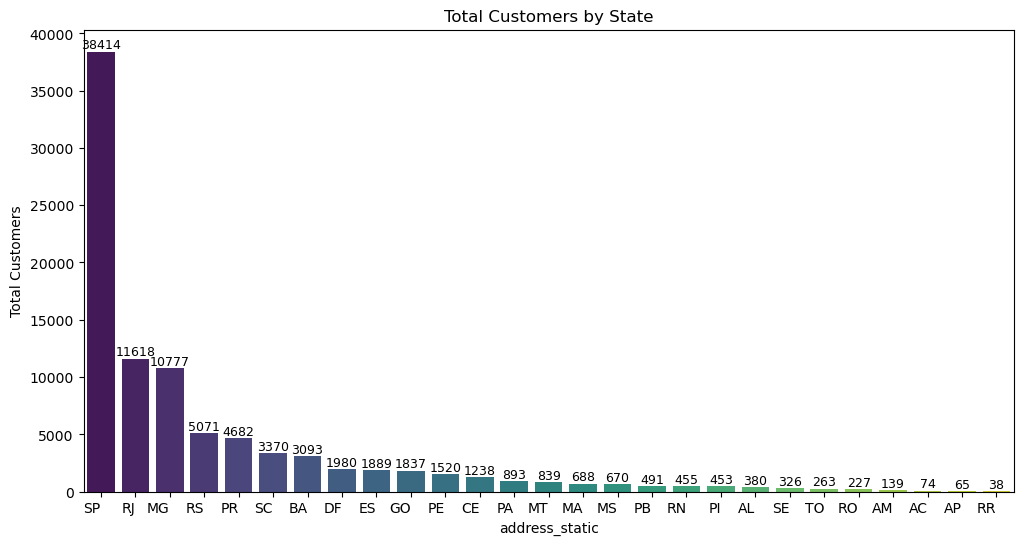

In [43]:
# Buat Visualisasi
# Urutkan data berdasarkan 'total_unique_customers' dari terbesar ke terkecil
customer_per_state = customer_per_state.sort_values(by='total_unique_customers', ascending=False)

# Buat figure dengan ukuran 12x6 inci
plt.figure(figsize=(12,6))

# Gunakan warna yang sesuai dari palet 'viridis'
ax = sns.barplot(x='address_static', y='total_unique_customers', 
                 data=customer_per_state, 
                 palette=sns.color_palette("viridis", n_colors=len(customer_per_state)))
# Tambahkan angka di atas setiap batang dengan lebih rapi
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=9, color='black', label_type='edge')
# Rotasi label sumbu-x agar lebih mudah dibaca
plt.xticks(rotation=0, ha='right')
# Beri label pada sumbu-x
plt.xlabel("address_static")
# Beri label pada sumbu-y
plt.ylabel("Total Customers")
# Beri judul pada grafik
plt.title("Total Customers by State")
# Tampilkan plot
plt.show()

### Count Unique Customer Id by City 
- Mempersempit fokus ke tingkat kota, menunjukkan kota-kota dengan konsentrasi pelanggan tertinggi.
- Membantu dalam mengidentifikasi area dengan potensi pertumbuhan pasar.

In [44]:
# Menghitung jumlah unique customer_id berdasarkan address_city
customer_per_city = df.groupby('address_city')['customer_unique_id'].nunique().reset_index()
customer_per_city.rename(columns={'customer_unique_id': 'total_unique_customers'}, inplace=True)

In [45]:
# Melihat hasil
customer_per_city.head()

,address_city,total_unique_customers
0,abadia dos dourados,3
1,abadiania,1
2,abaete,10
3,abaetetuba,11
4,abaiara,2


In [46]:
# Melihat banyykny customer per kota / city
customer_per_city.groupby('address_city')['total_unique_customers'].sum().sort_values(ascending=False).head(10)

address_city
sao paulo                14214
rio de janeiro            6197
belo horizonte            2546
brasilia                  1975
curitiba                  1412
campinas                  1339
porto alegre              1266
salvador                  1121
guarulhos                 1086
sao bernardo do campo      864
Name: total_unique_customers, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_10356\3020751944.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='total_unique_customers', y='address_city', data=top_cities, palette='Blues_r')


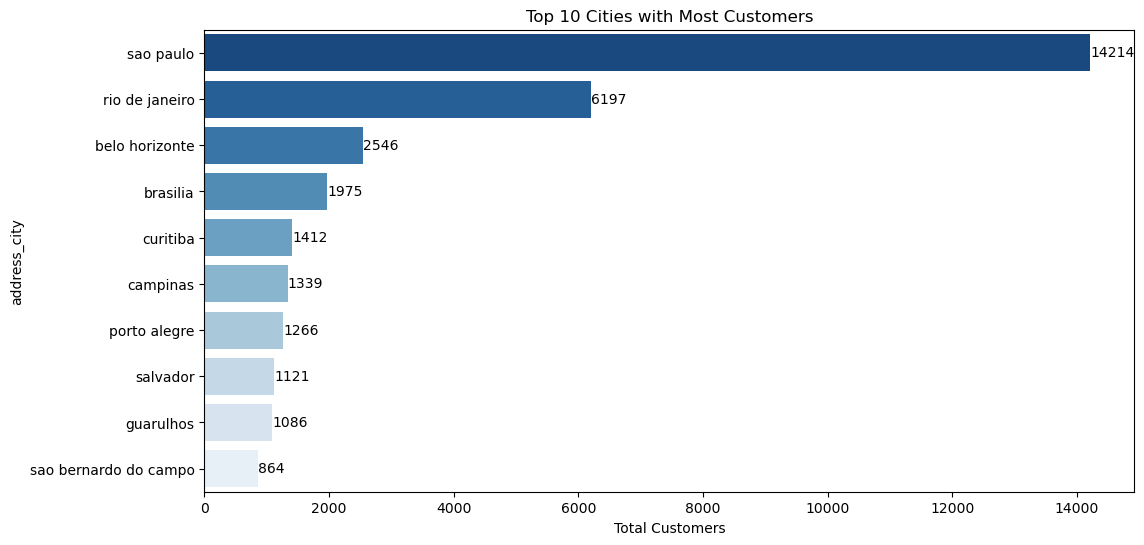

In [47]:
# Buat Visualisasi
# Pilih 10 kota dengan jumlah pelanggan unik terbanyak
top_cities = customer_per_city.sort_values(by='total_unique_customers', ascending=False).head(10)

# Buat figure dengan ukuran 12x6 inci
plt.figure(figsize=(12,6))
# Buat barplot horizontal
ax = sns.barplot(x='total_unique_customers', y='address_city', data=top_cities, palette='Blues_r')
# Tambahkan angka di setiap batang
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, color='black', label_type='edge')
# Beri label pada sumbu-x dan sumbu-y
plt.xlabel("Total Customers")
plt.ylabel("address_city")
plt.title("Top 10 Cities with Most Customers")
plt.show()

## Insight & Suggestion/Recommendation from Top 3 Customer Cities & States
Top 3 negara bagian (state) dengan jumlah pelanggan unik terbanyak:

- SP (Sao Paulo): 38.414 pelanggan

- RJ (Rio de Janeiro): 11.618 pelanggan

- MG (Minas Gerais): 10.777 pelanggan

Ketiga negara bagian ini termasuk dalam wilayah tenggara Brasil, yang merupakan pusat ekonomi dan populasi terbesar di negara tersebut.

➤ Insight: Konsentrasi pelanggan di wilayah tenggara menunjukkan bahwa strategi pemasaran dan logistik utama sebaiknya difokuskan di area ini.

Top 3 kota dengan pelanggan terbanyak:

- Sao Paulo: 14.214 pelanggan

- Rio de Janeiro: 6.197 pelanggan

- Belo Horizonte: 2.546 pelanggan

Sao Paulo sendiri menyumbang ~37% dari total pelanggan di negara bagian SP, menegaskan posisinya sebagai hub e-commerce terbesar.

➤ Insight: Sao Paulo bukan hanya pusat ekonomi, tetapi juga menjadi kota dengan potensi konversi tinggi. Promosi lokal, kampanye diskon, dan penguatan layanan di kota ini akan berdampak besar terhadap penjualan.

---
### Suggestion/Recommendation

- Fokus campaign marketing dan distribusi serta optimalisasi logistik bisa difokuskan ke Top 3 State & City yang banyak customer.



### Customer Segmentation by Frequency Order
 - Membuat segmentasi customer berdasarkan seberapa banyak transaksi yang dilakukan oleh masing-masing customer.
 - Dibagi menjadi 2 segment, yaitu 'little' jika total order <= 5 dan 'lot' jika total order > 5.

In [48]:
# Menghitung total order per customer
total_orders_per_customer = df.groupby('customer_unique_id')['order_id'].count().reset_index()
total_orders_per_customer.rename(columns={'order_id': 'total_orders'}, inplace=True)

# Menambahkan kolom frekuensi order
total_orders_per_customer['order_frequency'] = total_orders_per_customer['total_orders'].apply(lambda x: 'a little' if x < 5 else 'a lot')

In [49]:
# Melihat hasil
total_orders_per_customer

,customer_unique_id,total_orders,order_frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,a little
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,a little
2,0000f46a3911fa3c0805444483337064,1,a little
3,0000f6ccb0745a6a4b88665a16c9f078,1,a little
4,0004aac84e0df4da2b147fca70cf8255,1,a little
...,...,...,...
91448,fffcf5a5ff07b0908bd4e2dbc735a684,2,a little
91449,fffea47cd6d3cc0a88bd621562a9d061,1,a little
91450,ffff371b4d645b6ecea244b27531430a,1,a little
91451,ffff5962728ec6157033ef9805bacc48,1,a little


In [50]:
total_orders_per_customer['order_frequency'].value_counts()

order_frequency
a little    90602
a lot         851
Name: count, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_10356\4056538926.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_freq_counts.index, y=order_freq_counts.values, palette=['#1f77b4', '#4f92c3'])


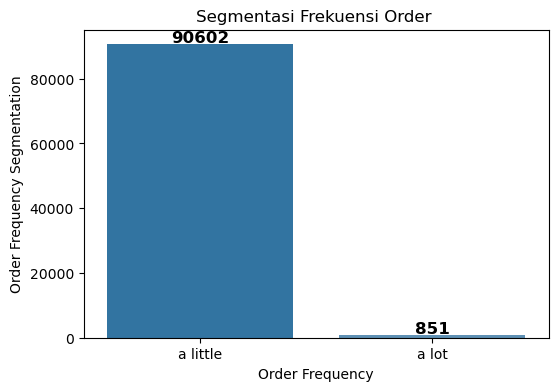

In [51]:
# Hitung jumlah pelanggan berdasarkan kategori order_frequency
order_freq_counts = total_orders_per_customer['order_frequency'].value_counts()

# Membuat figure
plt.figure(figsize=(6, 4))

# Membuat bar chart dengan warna biru
sns.barplot(x=order_freq_counts.index, y=order_freq_counts.values, palette=['#1f77b4', '#4f92c3'])

# Menambahkan label di atas setiap bar
for i, v in enumerate(order_freq_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontsize=12, fontweight='bold', color='black')

# Menambahkan label sumbu dan judul
plt.xlabel("Order Frequency")
plt.ylabel("Order Frequency Segmentation")
plt.title("Segmentasi Frekuensi Order ")
plt.show()

## Insight
- Sebagian besar customer termasuk dalam segmen **a little**. Jumlah customer pada segmen **a lot** jauh lebih sedikit.
- Frekuensi transaksi OLIST E-commerce didominasi oleh transaksi yang frekuensinya kecil atau kurang dari 5 kali dalam jangka waktu 2 tahun.


                       mean         std  median   min      max
order_frequency                                               
a little         141.419490  190.252647   92.97  7.28  6929.31
a lot            111.381521  141.106295   75.07  6.08  2511.75


C:\Users\W10\AppData\Local\Temp\ipykernel_10356\3476154763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='order_frequency', y='total_order_value', data=total_orders_per_customer, palette='Set1')


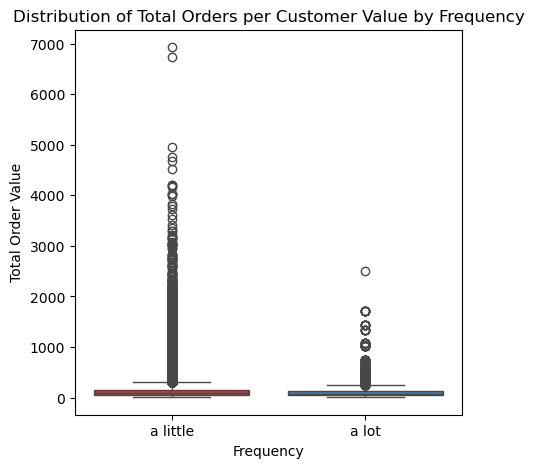

In [52]:
# Gabungkan total_orders_per_customer dengan dataframe
total_orders_per_customer = pd.merge(total_orders_per_customer, df[['customer_unique_id', 'total_order_value']], on='customer_unique_id', how='left')

# Grouping dan Hitung Statistik
grouped_data = total_orders_per_customer.groupby('order_frequency')['total_order_value'].agg(['mean', 'std', 'median', 'min', 'max'])
print(grouped_data)
# Membuat box plot
plt.figure(figsize=(5, 5))
sns.boxplot(x='order_frequency', y='total_order_value', data=total_orders_per_customer, palette='Set1')
plt.title('Distribution of Total Orders per Customer Value by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Total Order Value')
plt.show()

- Terliha jelas bahwa kelompok **a little** memiliki median nilai order yang lebih tinggi dan variabilitas yang lebih besar dibandingkan kelompok **a lot**.
- Selain itu, terlihat beberapa outlier pada kedua kelompok, terutama pada kelompok **a little** dengan nilai order yang sangat tinggi.

### Analysis Customer Behaviour by Time Difference Day Order
- Mengelompokkan customer berdasarkan frekuensi dan rentang waktu transaksi pertama dan terakhir.

In [54]:
# 1. Tanggal pembelian pertama & terakhir per customer
customer_purchase_dates = df.groupby('customer_unique_id').agg(
    first_purchase_date=('order_purchase_timestamp', 'min'),
    last_purchase_date=('order_purchase_timestamp', 'max')
).reset_index()

# 2. Hitung total order pada tanggal first_purchase
orders_by_timestamp = df.groupby(['customer_unique_id', 'order_purchase_timestamp']).agg(
    total_orders=('order_id', 'count')
).reset_index()

total_orders_on_first = pd.merge(
    customer_purchase_dates[['customer_unique_id', 'first_purchase_date']],
    orders_by_timestamp,
    left_on=['customer_unique_id', 'first_purchase_date'],
    right_on=['customer_unique_id', 'order_purchase_timestamp'],
    how='left'
).drop(columns='order_purchase_timestamp')

total_orders_on_first.rename(columns={'total_orders': 'total_orders_on_first_purchase'}, inplace=True)

# 3. Hitung total order pada tanggal last_purchase
total_orders_on_last = pd.merge(
    customer_purchase_dates[['customer_unique_id', 'last_purchase_date']],
    orders_by_timestamp,
    left_on=['customer_unique_id', 'last_purchase_date'],
    right_on=['customer_unique_id', 'order_purchase_timestamp'],
    how='left'
).drop(columns='order_purchase_timestamp')

total_orders_on_last.rename(columns={'total_orders': 'total_orders_on_last_purchase'}, inplace=True)

# 4. Gabungkan semua ke satu tabel
customer_purchase_summary = customer_purchase_dates.merge(
    total_orders_on_first[['customer_unique_id', 'total_orders_on_first_purchase']],
    on='customer_unique_id',
    how='left'
).merge(
    total_orders_on_last[['customer_unique_id', 'total_orders_on_last_purchase']],
    on='customer_unique_id',
    how='left'
)

# 5. Hitung selisih jumlah order antara pembelian pertama dan terakhir
customer_purchase_summary['first_vs_last_purchase_difference'] = (
    customer_purchase_summary['total_orders_on_first_purchase'] -
    customer_purchase_summary['total_orders_on_last_purchase']
)

# Tampilkan hasil
customer_purchase_summary.head()

,customer_unique_id,first_purchase_date,last_purchase_date,total_orders_on_first_purchase,total_orders_on_last_purchase,first_vs_last_purchase_difference
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,1,0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,1,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,1,0


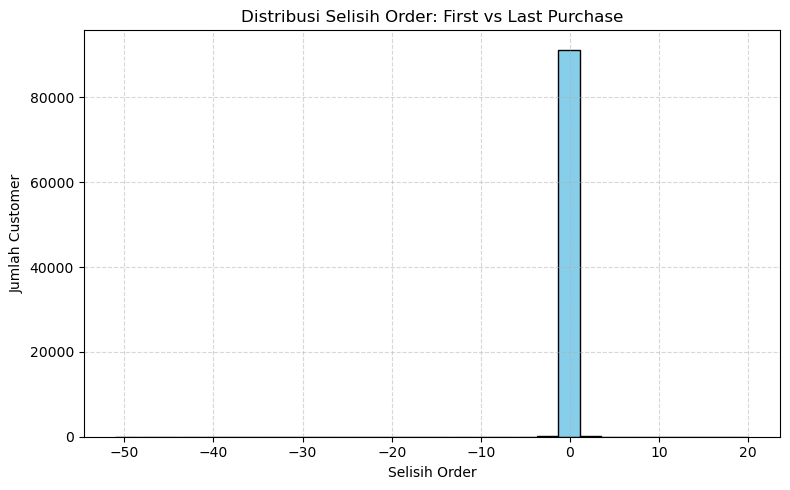

In [57]:
plt.figure(figsize=(8, 5))
plt.hist(customer_purchase_summary['first_vs_last_purchase_difference'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Selisih Order: First vs Last Purchase')
plt.xlabel('Selisih Order')
plt.ylabel('Jumlah Customer')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [59]:
# Kalkulasi total sum dari masing-masing kategori
totals = {
    'First Purchase': customer_purchase_summary['total_orders_on_first_purchase'].sum(),
    'Last Purchase': customer_purchase_summary['total_orders_on_last_purchase'].sum(),
    'Difference': customer_purchase_summary['first_vs_last_purchase_difference'].sum()
}


In [60]:
totals

{'First Purchase': 109378, 'Last Purchase': 109339, 'Difference': 39}

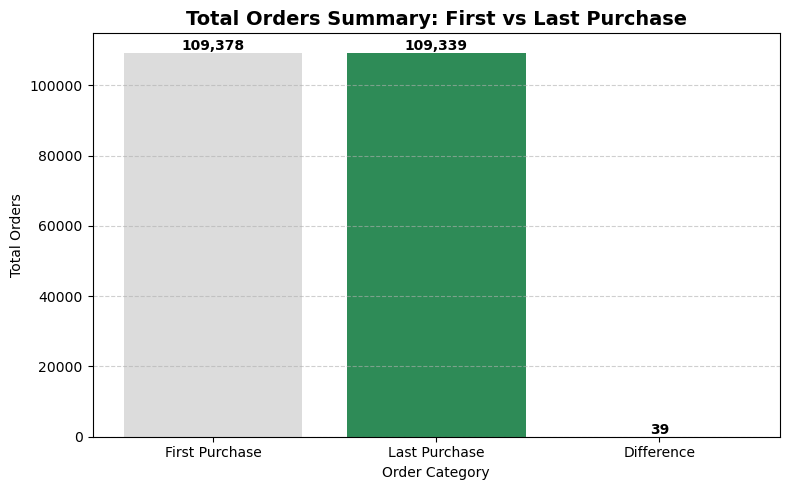

In [58]:
# Kalkulasi total sum dari masing-masing kategori
totals = {
    'First Purchase': customer_purchase_summary['total_orders_on_first_purchase'].sum(),
    'Last Purchase': customer_purchase_summary['total_orders_on_last_purchase'].sum(),
    'Difference': customer_purchase_summary['first_vs_last_purchase_difference'].sum()
}

# Buat bar chart untuk total orders summary

plt.figure(figsize=(8, 5))
bars = plt.bar(totals.keys(), totals.values(), color=['gainsboro', 'seagreen', 'green'])

# Tambahkan label angka pada masing-masing bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{int(height):,}', 
        ha='center', 
        va='bottom', 
        fontsize=10,
        fontweight='bold'
    )

plt.title('Total Orders Summary: First vs Last Purchase', fontsize=14, fontweight='bold')
plt.xlabel('Order Category')
plt.ylabel('Total Orders')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Insight : 
- Selisih hanya 39 pesanan dari lebih dari 100 ribu transaksi menunjukkan bahwa jumlah pesanan yang dilakukan saat pembelian pertama dan terakhir hampir seimbang.

- Selisih pesanan yang nyaris nol antara pembelian pertama dan terakhir menunjukkan bahwa sebagian besar pelanggan hanya melakukan satu kali pembelian (**Single Order**).

- Ini diperkuat dari visualisasi selisih order grafik di angka 0 jumlah customer > 80000


## Conclusions
1. Distribusi Customer Berdasarkan Wilayah
- Berdasarkan distribusi customer berdsarkan wilayah, di state Sao Paulo (SP) memiliki jumlah customer terbanyak yang menunjukkan jumlah yang signifikan. Jika dilihat berdasarkan kota, dominasi tetap terlihat pada kota Sao Paulo dan Rio de Janeiro, sementara kota-kota lainnya mencatat jumlah pelanggan yang lebih rendah.
- Ini menunjukkan bahwa area ini merupakan pasar utama dan perlu menjadi fokus strategi bisnis.
2. Segmentasi  Customer
- Kelompok **a lot** adalah pelanggan setia yang sering melakukan pembelian dalam jangka waktu panjang. Mereka merupakan aset penting bagi perusahaan dan perlu dijaga loyalitasnya dengan layanan dan program khusus.
- Kelompok **a little** adalah pelanggan yang jarang melakukan pembelian. Untuk mereka yang hanya membeli sekali, perlu ditingkatkan pengalaman pertama agar mau kembali. Sementara yang pernah membeli tapi lama tidak aktif bisa ditargetkan dengan promosi atau pengingat berkala agar kembali bertransaksi.
3. Selisih Order
- Selisih pesanan sebagian besar 0 antara pembelian pertama dan terakhir menunjukkan bahwa sebagian besar pelanggan hanya melakukan satu kali pembelian (**Single Order**).
---
### Suggestion/Recommendation
- Prioritas Target Pasar fokus pemasaran ke wilayah dengan jumlah customer tinggi yaitu Sao Paulo dan Rio de Janeiro
- Dorong repeat order dari customer **Single Order**, seperti kirim email promo personalisasi.
- Buat program loyalitas atau reward untuk customer **a lot**.

# Order Behaviour


- Mengelompokan dan menghitung rata-rata jumlah barang yang dipesan berdasarkan total customer_unique_id, dengan asumsi bahwa jika rata-ratanya di bawah 5 disebut 'a little', dan jika sama dengan atau lebih dari 5 disebut 'a lot'.

In [61]:
# Menghitung jumlah rata-rata item yang dipesan per customer
avg_items_per_customer = df.groupby('customer_unique_id')['order_item_id'].count().reset_index()
avg_items_per_customer.rename(columns={'order_item_id': 'avg_items_ordered'}, inplace=True)

# Menambahkan kolom kategori frekuensi order
# .apply(lambda x: ...) digunakan untuk menerapkan fungsi ke setiap baris (atau elemen) dalam sebuah kolom di DataFrame
avg_items_per_customer['order_frequency'] = avg_items_per_customer['avg_items_ordered'].apply(lambda x: 'a little' if x < 5 else 'a lot')

In [62]:
# Melihat hasil
avg_items_per_customer

,customer_unique_id,avg_items_ordered,order_frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,a little
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,a little
2,0000f46a3911fa3c0805444483337064,1,a little
3,0000f6ccb0745a6a4b88665a16c9f078,1,a little
4,0004aac84e0df4da2b147fca70cf8255,1,a little
...,...,...,...
91448,fffcf5a5ff07b0908bd4e2dbc735a684,2,a little
91449,fffea47cd6d3cc0a88bd621562a9d061,1,a little
91450,ffff371b4d645b6ecea244b27531430a,1,a little
91451,ffff5962728ec6157033ef9805bacc48,1,a little


In [63]:
avg_items_per_customer['order_frequency'].value_counts()

order_frequency
a little    90602
a lot         851
Name: count, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_10356\3935997358.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_freq_counts.index, y=order_freq_counts.values, palette='viridis')


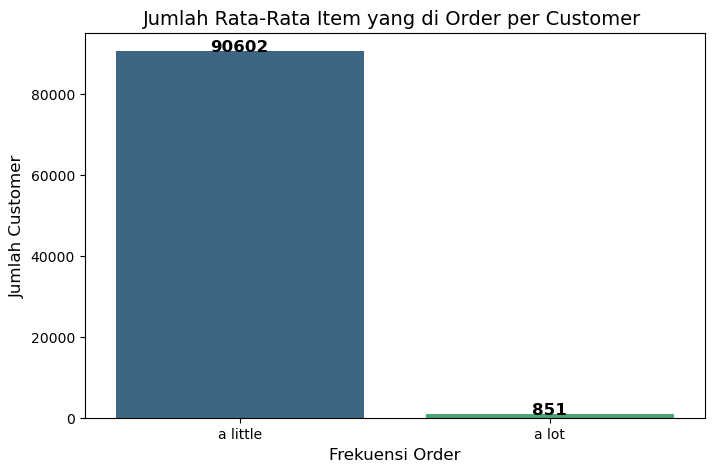

In [64]:
# Buat Visualisasi
# Menghitung jumlah customer dalam setiap kategori
order_freq_counts = avg_items_per_customer['order_frequency'].value_counts()

# Membuat bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=order_freq_counts.index, y=order_freq_counts.values, palette='viridis')

# Menampilkan angka di atas setiap batang
for i, v in enumerate(order_freq_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12, fontweight='bold')

# Menambahkan judul dan label
plt.title('Jumlah Rata-Rata Item yang di Order per Customer ', fontsize=14)
plt.xlabel('Frekuensi Order', fontsize=12)
plt.ylabel('Jumlah Customer', fontsize=12)

# Menampilkan plot
plt.show()

Berdasarkan visualisasi tersebut, terlihat bahwa sebagian besar customer melakukan pembelian secara tidak rutin. Sebanyak 90.602 customer termasuk dalam kategori **a little**, yaitu customer yang jarang berbelanja. Sementara itu, hanya 851 customer yang tergolong sebagai customer frekuensi dalam kategori **a lot**

### Avarege & Std Deviation per Item Category
 - Mengelompokkan data berdasarkan product_category_name_english dan menghitung statistik deskriptif (mean & std) untuk kolom product_weight_g.
 - Hasil dari data item_weight, dapat untuk memperkirakan biaya pengiriman dan penanganan produk berdasarkan berat rata-rata kategori.

In [65]:
# Menghitung rata-rata dan standar deviasi berat barang
item_weight = df.groupby('product_category_name_english')['product_weight_g'].agg({'mean', 'std'})
item_weight.sort_values(by='mean', ascending=False)

,std,mean
product_category_name_english,,
office_furniture,4795.625249,11241.560069
furniture_bedroom,5177.439018,10319.957983
home_appliances_2,7135.254917,9875.324427
kitchen_dining_laundry_garden_furniture,8158.100428,8777.252595
furniture_mattress_and_upholstery,10823.369111,8388.750000
...,...,...
fashion_sport,349.235619,340.000000
tablets_printing_image,64.339186,292.411765
fashion_childrens_clothes,203.540098,285.714286


C:\Users\W10\AppData\Local\Temp\ipykernel_10356\1037167436.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


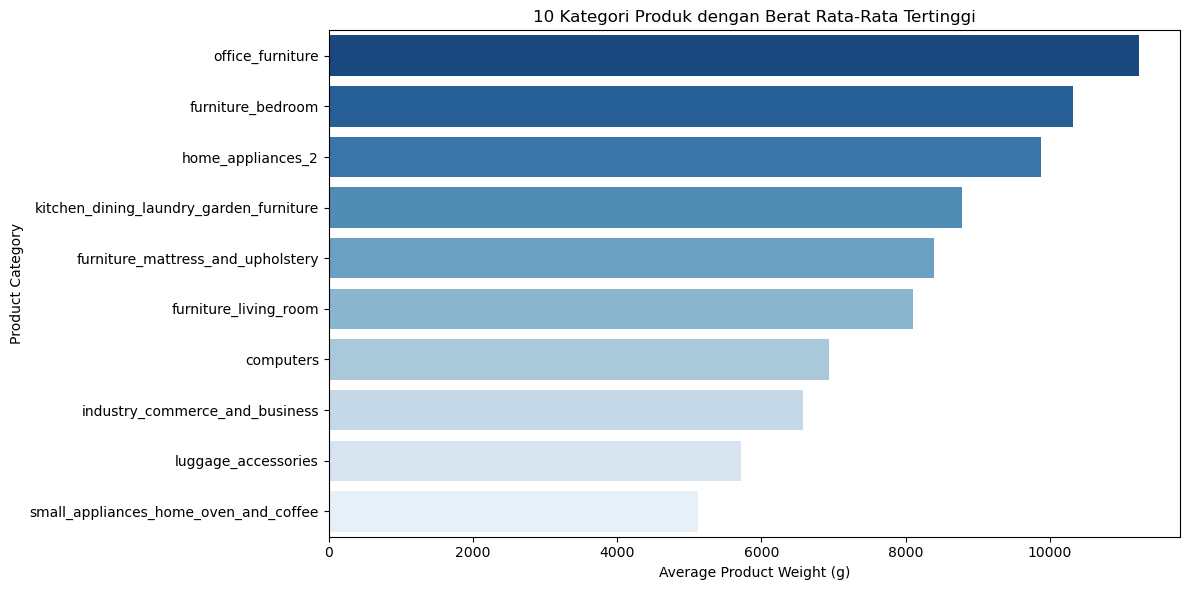

In [66]:
# Menghitung rata-rata dan standar deviasi berat barang
item_weight = df.groupby('product_category_name_english')['product_weight_g'].agg(['mean', 'std'])

# Mengambil 10 kategori teratas berdasarkan rata-rata berat
top10_weight = item_weight.sort_values(by='mean', ascending=False).head(10).reset_index()

# Plot barplot horizontal
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x='mean',
    y='product_category_name_english',
    data=top10_weight,
    palette='Blues_r'
)
plt.xlabel('Average Product Weight (g)')
plt.ylabel('Product Category')
plt.title('10 Kategori Produk dengan Berat Rata-Rata Tertinggi')
plt.tight_layout()
plt.show()


C:\Users\W10\AppData\Local\Temp\ipykernel_10356\1751645501.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


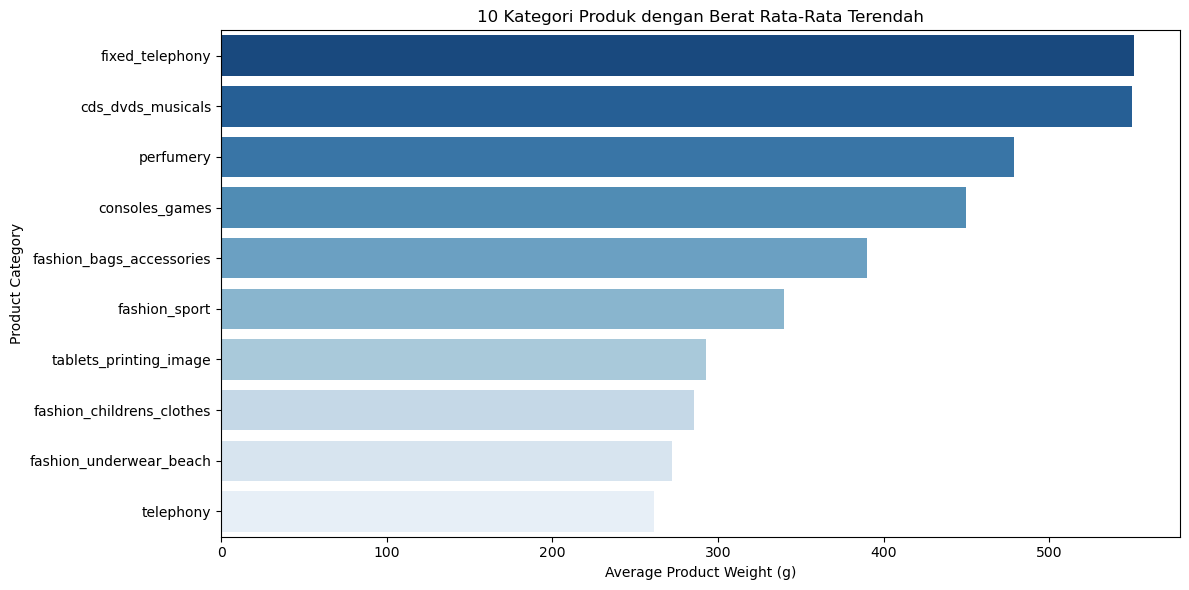

In [67]:
# Menghitung rata-rata dan standar deviasi berat barang
item_weight = df.groupby('product_category_name_english')['product_weight_g'].agg(['mean', 'std'])

# Mengambil 10 kategori terbawah berdasarkan rata-rata berat
top10_weight = item_weight.sort_values(by='mean', ascending=False).tail(10).reset_index()

# Plot barplot horizontal
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x='mean',
    y='product_category_name_english',
    data=top10_weight,
    palette='Blues_r'
)
plt.xlabel('Average Product Weight (g)')
plt.ylabel('Product Category')
plt.title('10 Kategori Produk dengan Berat Rata-Rata Terendah')
plt.tight_layout()
plt.show()


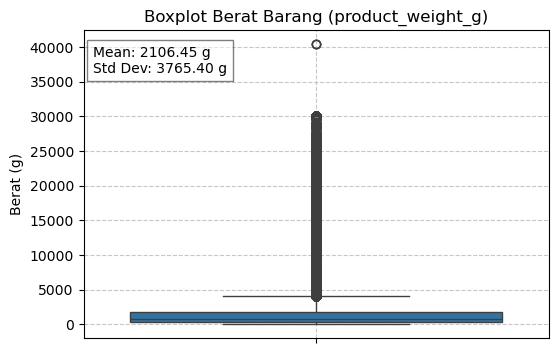

In [68]:
# Menghitung rata-rata dan standar deviasi berat barang
item_weight = df['product_weight_g'].agg(['mean', 'std'])

# Menyimpan nilai mean dan std ke dalam variabel
mean_weight = item_weight['mean']
std_weight = item_weight['std']

# Membuat boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(y=df['product_weight_g'])
plt.title('Boxplot Berat Barang (product_weight_g)')
plt.ylabel('Berat (g)')
plt.grid(True, linestyle='--', alpha=0.7)

# Menampilkan mean dan standar deviasi
txt = f"Mean: {mean_weight:.2f} g\nStd Dev: {std_weight:.2f} g"
plt.text(0.02, 0.95, txt, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Menampilkan plot
plt.show()

Analisis Berat Produk pada Dataset
1. Top 10 Kategori Produk Paling Berat
    - Produk dengan rata-rata berat tertinggi didominasi oleh furniture dan home appliances.

    - Kategori paling berat: office_furniture, furniture_bedroom, dan home_appliances_2.

    - Produk-produk ini cenderung besar dan berat, berpengaruh pada biaya logistik yang lebih tinggi.

2. Top 10 Kategori Produk Paling Ringan
    - Produk dengan berat rata-rata paling ringan berasal dari kategori kecil dan ringan seperti cds_dvds_musicals, perfumery, dan fashion_underwear_beach.

    - Ringan dan mudah dikemas, menguntungkan untuk pengiriman cepat dan biaya logistik rendah.

3. Distribusi Berat Produk (Boxplot)
    - Rata-rata berat produk: 2.106 gram.

    - Standar deviasi: 3.765 gram → menunjukkan variasi berat yang sangat besar antar produk.

    - Terlihat bahwa mayoritas produk beratnya di bawah rata-rata, tetapi terdapat beberapa outlier (produk sangat berat) yang menyebabkan distribusi positively skewed (condong ke kanan).


4. Insight dan Implikasi Bisnis:
    - Segmentasi Pengiriman: Produk berat seperti furnitur memerlukan strategi pengiriman khusus, mungkin dengan mitra logistik berat. Sebaliknya, produk ringan cocok untuk layanan ekspres.

    - Optimasi Biaya: Menyadari variasi berat yang besar bisa membantu dalam pengelolaan gudang dan penetapan ongkos kirim yang lebih akurat.

    - Bundle Strategy: Kategori ringan bisa dibundling untuk meningkatkan nilai transaksi, tanpa menambah beban logistik secara signifikan.

### The most frequent order times by month and day, and its time (morning, afternoon, evening, or night)

In [69]:
# Definisikan fungsi untuk mengkategorikan waktu berdasarkan jam
def categorize_time(hour):
    """
    Mengkategorikan waktu berdasarkan jam.
    - Morning: 05:00 - 11:59
    - Afternoon: 12:00 - 16:59
    - Evening: 17:00 - 20:59
    - Night: 21:00 - 04:59
    """
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

# Terapkan fungsi untuk membuat kolom baru 'time_category'
df['time_category'] = df['hour'].apply(categorize_time)

# Kelompokkan data berdasarkan bulan, hari, dan kategori waktu, lalu hitung jumlah order
order_frequency = df.groupby(['month', 'day', 'time_category'])['order_id'].count().reset_index()

# Ganti nama kolom hasil agregasi agar lebih informatif
order_frequency.rename(columns={'order_id': 'order_count'}, inplace=True)

# Urutkan berdasarkan bulan, hari, dan jumlah order secara menurun (agar bisa ambil yang paling sering)
order_frequency = order_frequency.sort_values(by=['month', 'day', 'order_count'], ascending=[True, True, False])

# Ambil hanya kategori waktu dengan order terbanyak untuk setiap kombinasi bulan dan hari
most_frequent_order_times = order_frequency.groupby(['month', 'day']).first().reset_index()

In [70]:
# Tampilkan hasil akhir
most_frequent_order_times.head()

,month,day,time_category,order_count
0,1,Friday,afternoon,421
1,1,Monday,afternoon,486
2,1,Saturday,evening,300
3,1,Sunday,evening,284
4,1,Thursday,afternoon,465


C:\Users\W10\AppData\Local\Temp\ipykernel_10356\623198590.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='order_count', data=order_by_month, ax=axes[0], palette='Blues')
C:\Users\W10\AppData\Local\Temp\ipykernel_10356\623198590.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day', y='order_count', data=order_by_day, ax=axes[1], palette='Greens')
C:\Users\W10\AppData\Local\Temp\ipykernel_10356\623198590.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_category', y='order_count', data=order_by_time, ax=ax

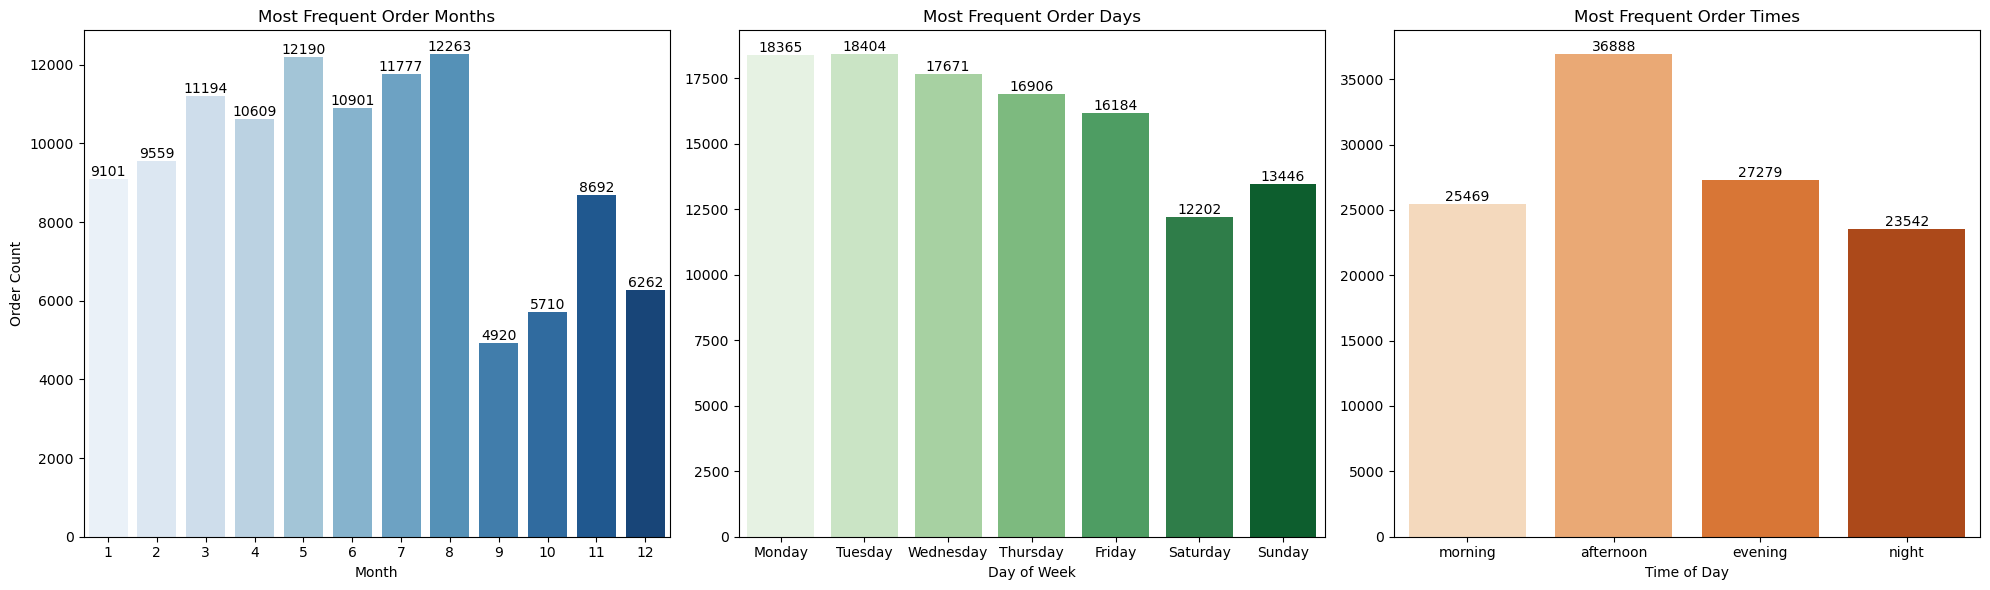

In [74]:
# Hitung jumlah order per bulan
order_by_month = df.groupby('month')['order_id'].count().reset_index(name='order_count')
# Hitung jumlah order per hari
order_by_day = df.groupby('day')['order_id'].count().reset_index(name='order_count')
# Hitung jumlah order per kategori waktu
order_by_time = df.groupby('time_category')['order_id'].count().reset_index(name='order_count')

# Urutkan hari
order_by_day['day'] = pd.Categorical(
    order_by_day['day'],
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)
order_by_day.sort_values('day', inplace=True)

# Urutkan kategori waktu (kalau kamu ingin urutan tertentu)
time_order = ['morning', 'afternoon', 'evening', 'night']
order_by_time['time_category'] = pd.Categorical(order_by_time['time_category'], categories=time_order, ordered=True)
order_by_time.sort_values('time_category', inplace=True)

# Buat figure dan subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Barplot per bulan
sns.barplot(x='month', y='order_count', data=order_by_month, ax=axes[0], palette='Blues')
axes[0].set_title('Most Frequent Order Months')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Order Count')
# Menampilkan label nilai di atas batang pada plot pertama
for p in axes[0].containers:
    axes[0].bar_label(p, fmt='%d', fontsize=10)
    
# Barplot per hari
sns.barplot(x='day', y='order_count', data=order_by_day, ax=axes[1], palette='Greens')
axes[1].set_title('Most Frequent Order Days')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('')
# Menampilkan label nilai di atas batang pada plot pertama
for p in axes[1].containers:
    axes[1].bar_label(p, fmt='%d', fontsize=10)

# Barplot per kategori waktu
sns.barplot(x='time_category', y='order_count', data=order_by_time, ax=axes[2], palette='Oranges')
axes[2].set_title('Most Frequent Order Times')
axes[2].set_xlabel('Time of Day')
axes[2].set_ylabel('')
# Menampilkan label nilai di atas batang pada plot pertama
for p in axes[2].containers:
    axes[2].bar_label(p, fmt='%d', fontsize=10)
    
# Tampilkan semua grafik
plt.tight_layout()
plt.show()

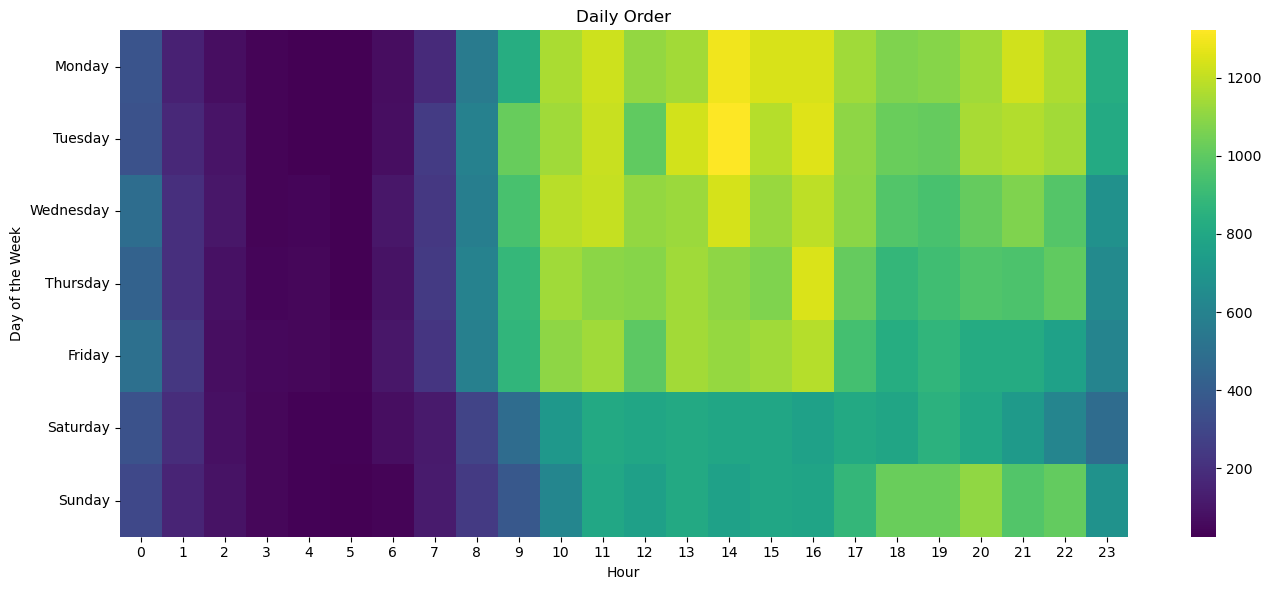

In [93]:
# Kelompokkan berdasarkan day_name dan jam untuk menghitung total order
heatmap_data = df.groupby(['day', 'hour']).size().unstack(fill_value=0)

# Mengurutkan hari berdasarkan urutan yang benar
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

# Plotting the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, cbar=True)
plt.title('Daily Order')
plt.xlabel('Hour')
plt.ylabel('Day of the Week')
plt.tight_layout()
plt.show()

### Kesimpulan Pola Pemesanan Berdasarkan Waktu
Transaksi customer paling sibuk pada jam 10:00-16:00 pada weekday. Hari Sabtu penjualan terendah dan stabil sepanjang hari. Sedangkan hari Minggu customer mulai banyak transaksi pada jam 18:00–22:00 malam. 

---
### Suggestion/Recommendation
- Jam/hari sibuk: Buat kampanye iklan, diskon, flash sale, dan push notification pada weekday, jam 10:00–16:00 dan jam 18:00-22:00 pada hari Minggu untuk meningkatkan urgensi pembelian.
- Hari dan Jam Sepi : Terapkan promosi berbeda untuk mendorong pembelian di waktu yang kurang optimal.


### Classification Average Order Value per Customer
- Memberikan informasi tentang rata-rata nilai order untuk setiap customer dan mengklasifikasikannya ke dalam kategori harga yaitu expensive, normal, dan cheap.
- Rata-rata harga pesanan untuk setiap customer dengan asumsi: harga di atas 2500 disebut 'expensive', harga antara 1000 hingga 2500 disebut 'normal', dan harga di bawah 1000 disebut 'cheap'.

In [82]:
# Menghitung total order value
df['total_order_value'] = df['price'] + df['freight_value']

# Menghitung rata-rata nilai order per customer
avg_order_value_per_customer = df.groupby('customer_unique_id')['total_order_value'].mean().reset_index()
avg_order_value_per_customer.rename(columns={'total_order_value': 'avg_order_value'}, inplace=True)

# Mengkategorikan harga order
def classify_order_price(value):
    if value > 2500:
        return 'Expensive'
    elif 1000 <= value <= 2500:
        return 'Normal'
    else:
        return 'Cheap'

avg_order_value_per_customer['price_classify'] = avg_order_value_per_customer['avg_order_value'].apply(classify_order_price)

In [83]:
# Melihat hasil
avg_order_value_per_customer.head()

,customer_unique_id,avg_order_value,price_classify
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,Cheap
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,Cheap
2,0000f46a3911fa3c0805444483337064,86.22,Cheap
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,Cheap
4,0004aac84e0df4da2b147fca70cf8255,196.89,Cheap


In [84]:
avg_order_value_per_customer['price_classify'].value_counts()

price_classify
Cheap        90574
Normal         820
Expensive       59
Name: count, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_10356\3981402222.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


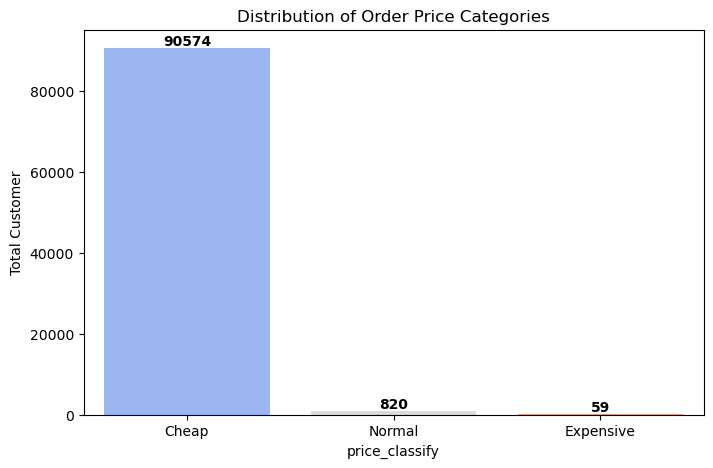

In [85]:
# Membuat ukuran plot
plt.figure(figsize=(8, 5))

# Membuat countplot dengan urutan kategori
ax = sns.countplot(
    x='price_classify', 
    data=avg_order_value_per_customer, 
    palette='coolwarm', 
    order=['Cheap', 'Normal', 'Expensive']
)

# Menambahkan angka di atas setiap batang
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'),  # Menampilkan angka tanpa desimal
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posisi teks
        ha='center', va='bottom', fontsize=10, fontweight='bold', color='black'
    )

# Menambahkan judul dan label
plt.title('Distribution of Order Price Categories')
plt.xlabel('price_classify')
plt.ylabel('Total Customer')

# Menampilkan plot
plt.show()

Mayoritas customer cenderung membeli produk dengan harga murah, terlihat dari 90.574 pesanan yang termasuk dalam kategori **Cheap**. Sementara itu, hanya 820 pesanan berada di kategori **Normal**, dan sangat sedikit pelanggan yang membeli produk **Expensive**, yaitu hanya 59 pesanan.

C:\Users\W10\AppData\Local\Temp\ipykernel_10356\159832967.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=order_counts.index, y=order_counts.values, palette='coolwarm', order=['Cheap', 'Normal', 'Expensive'], ax=axes[0])


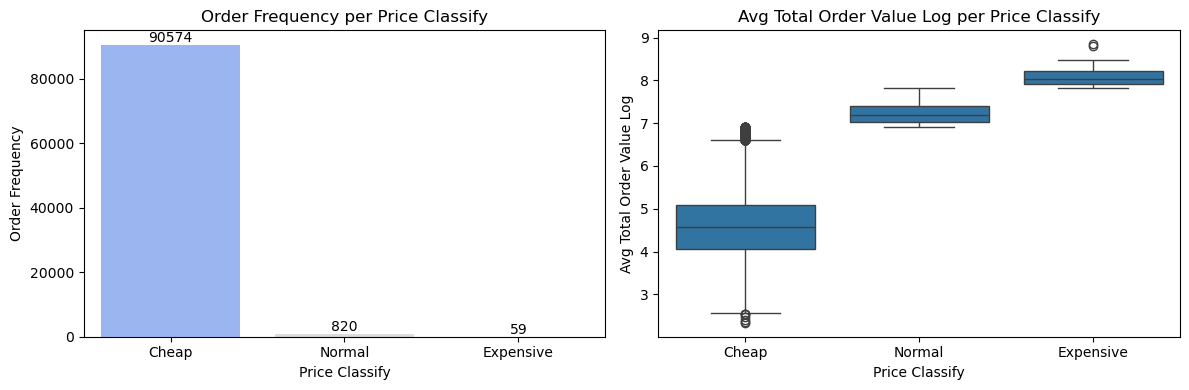

                       mean         std    median          min      max
price_classify                                                         
Cheap            132.271654  124.797070    95.220     9.341429   997.37
Expensive       3325.032627  874.499093  3042.360  2512.530000  6929.31
Normal          1420.627555  362.094795  1323.545  1002.710000  2467.33


In [86]:
# Membuat grafik
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Sesuaikan figsize

# Menghitung jumlah pesanan per kategori price_classify
order_counts = avg_order_value_per_customer['price_classify'].value_counts()

# Barplot pertama (Order Frequency per Price Classify)
ax = sns.barplot(x=order_counts.index, y=order_counts.values, palette='coolwarm', order=['Cheap', 'Normal', 'Expensive'], ax=axes[0])
for container in ax.containers[0:]:
    ax.bar_label(container)
axes[0].set_title('Order Frequency per Price Classify')
axes[0].set_xlabel('Price Classify')
axes[0].set_ylabel('Order Frequency')

# Menambahkan kolom log transform untuk avg_order_value
avg_order_value_per_customer['avg_order_value_log'] = np.log1p(avg_order_value_per_customer['avg_order_value'])

# Boxplot kedua (Avg Total Order Value Log per Price Classify)
sns.boxplot(x='price_classify', y='avg_order_value_log', data=avg_order_value_per_customer, order=['Cheap', 'Normal', 'Expensive'], ax=axes[1])
axes[1].set_title('Avg Total Order Value Log per Price Classify')
axes[1].set_xlabel('Price Classify')
axes[1].set_ylabel('Avg Total Order Value Log')

plt.tight_layout()
plt.show()

# Grouping dan Hitung Statistik
grouped_data_order_price = avg_order_value_per_customer.groupby('price_classify')['avg_order_value'].agg(['mean', 'std', 'median', 'min', 'max'])
print(grouped_data_order_price)

### Insight
- Kategori **Cheap** cenderung memiliki frekuensi order tertinggi, diikuti oleh **Normal**, dan terakhir **Expensive**.
- Namun kategori **Normal** dan **Expensive** memberikan nilai transaksi rata-rata yang lebih tinggi.
---
### Suggestion/Recommendation
- Terapkan strategi upselling produk kategori Cheap ke produk kategori lebih tinggi.
- Kategori Normal dan Expensive memiliki nilai transaksi rata-rata lebih tinggi, dorong penjualannya melalui promosi dan bundling.


#### Populer Payment Methods & Preference Product Category per Customer

- Memberikan informasi metode pembayaran dan kategori barang yang populer

In [87]:
# Menampilkan metode pembayaran paling populer
df['payment_type'].value_counts()

payment_type
credit_card    83519
boleto         22015
voucher         6022
debit_card      1622
Name: count, dtype: int64

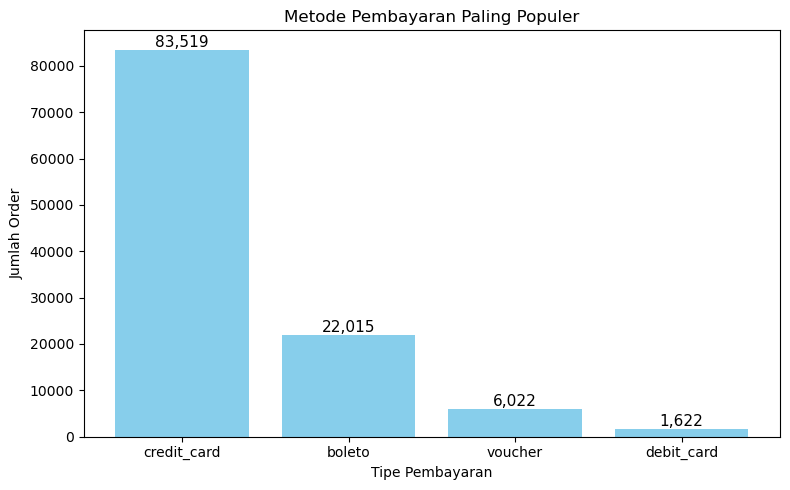

In [88]:
# Hitung jumlah masing-masing payment_type
payment_counts = df['payment_type'].value_counts()

plt.figure(figsize=(8,5))
bars = plt.bar(payment_counts.index, payment_counts.values, color='skyblue')

plt.title('Metode Pembayaran Paling Populer')
plt.xlabel('Tipe Pembayaran')
plt.ylabel('Jumlah Order')

# Tambahkan angka di atas setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval):,}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

### Insight
Credit Card menjadi metode pembayaran yang sangat dominan dengan 83,519 transaksi 

Preferensi Konsumen:
- Konsumen sangat mengutamakan kemudahan dan fleksibilitas pembayaran
- Metode pembayaran tradisional (debit card) kurang diminati

---
### Suggestion/Recommendation
1. Optimalisasi Credit Card Experience:

- Pastikan proses pembayaran credit card berjalan lancar dan cepat
- Berikan cashback atau reward points khusus untuk pengguna credit card
- Kerjasama dengan berbagai provider credit card untuk memperluas jangkauan

2. Strategi Peningkatan Metode Alternatif:

- Debit Card: Lakukan promosi khusus untuk meningkatkan penggunaan debit card
- Voucher: Kembangkan program voucher yang lebih menarik
- Pertimbangkan menambah metode pembayaran digital modern (e-wallet, QRIS, dll)

3. Fokus Bisnis & Marketing:

- Alokasikan resource utama untuk mengoptimalkan payment gateway credit card
- Buat campaign untuk mengedukasi benefit penggunaan metode pembayaran alternatif
- Pertimbangkan memberikan diskon khusus untuk diversifikasi metode pembayaran

4. Risk Management:

- Jangan terlalu bergantung pada satu metode pembayaran
- Siapkan backup system untuk credit card payment
- Monitor fraud detection khususnya untuk transaksi credit card yang tinggi

5. Future Development:

- Pertimbangkan integrasi dengan digital wallet populer
- Analisis lebih lanjut mengapa debit card sangat rendah penggunaannya

In [89]:
# Kelompokkan data berdasarkan customer dan jenis metode pembayaran,
# lalu hitung jumlah order untuk kombinasi tersebut sebagai preferensi pembayaran
payment_preference = df.groupby(['customer_unique_id', 'payment_type'])['order_id'].count().reset_index()

# Ganti nama kolom 'order_id' menjadi 'frequency' untuk merepresentasikan jumlah transaksi
payment_preference.rename(columns={'order_id': 'frequency'}, inplace=True)

# Untuk setiap customer, ambil metode pembayaran dengan frekuensi tertinggi (paling sering digunakan)
popular_payment = payment_preference.loc[
    payment_preference.groupby('customer_unique_id')['frequency'].idxmax()
]

# Tampilkan 10 sampel acak dari hasil metode pembayaran terpopuler per customer
display(popular_payment.sample(10))

# Hitung metode pembayaran yang paling umum digunakan di antara semua customer
mode_popular_payment = popular_payment['payment_type'].mode()[0]

# Hitung berapa banyak customer yang paling sering menggunakan metode 'credit_card'
count_popular_payment = popular_payment[popular_payment['payment_type'] == 'credit_card'].count()[0]

# Cetak hasil metode pembayaran terpopuler beserta jumlah customer yang menggunakannya
print(f"\nMetode pembayaran yang paling sering digunakan customer adalah {mode_popular_payment} sebanyak {count_popular_payment} kali")

,customer_unique_id,payment_type,frequency
60902,a5ed96c1f32643055492dd786e93418f,boleto,1
37550,66282b6b836a112be170f9d7a13498be,credit_card,1
25137,449ba3232212cc2b6459e3fcef52dee6,boleto,1
12937,23251e835cf26f5171a896b505025a01,credit_card,1
18644,32c7a0f2010fe6ea81c371b3b4905244,boleto,1
38912,69f0751c1d79721629c969cdbd8b7367,credit_card,1
56513,99f795fe81425dadda5f35f1f8f443f2,credit_card,1
3136,0870b1f9dc477ed671f26f98dfd658b8,credit_card,1
34666,5e4c21084ec2a785f22d323b1535ee3a,credit_card,1
22551,3d7201a23fdbd167157b7abd027f92a7,boleto,1



Metode pembayaran yang paling sering digunakan customer adalah credit_card sebanyak 70050 kali


C:\Users\W10\AppData\Local\Temp\ipykernel_10356\3306485393.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count_popular_payment = popular_payment[popular_payment['payment_type'] == 'credit_card'].count()[0]


In [90]:
# Kelompokkan data berdasarkan customer_unique_id dan product_category
product_preference = df.groupby(['customer_unique_id', 'product_category_name_english'])['order_id'].count().reset_index()

# Ubah nama kolom order_id menjadi frequency
product_preference.rename(columns={'order_id': 'frequency'}, inplace=True)

# Melihat kategori produk terpopuler untuk setiap customer
popular_product = product_preference.loc[product_preference.groupby('customer_unique_id')['frequency'].idxmax()]

# Gabungkan kedua tabel dengan semua kolom dari most_popular_product
populer_payment_method_and_product = pd.merge(popular_payment, popular_product[['customer_unique_id', 'product_category_name_english']], on='customer_unique_id', how='left')
populer_payment_method_and_product.sort_values(by='frequency', ascending=False)

,customer_unique_id,payment_type,frequency,product_category_name_english
55223,9a736b248f67d166d2fbb006bcb877c3,voucher,75,bed_bath_table
39997,6fbc7cdadbb522125f4b27ae9dee4060,voucher,36,office_furniture
89260,f9ae226291893fda10af7965268fb7f6,voucher,32,garden_tools
31029,569aa12b73b5f7edeaa6f2a01603e381,voucher,25,bed_bath_table
71652,c8460e4251689ba205045f3ea17884a1,credit_card,24,telephony
...,...,...,...,...
32530,5aaf237a53b94f01b6043dd1ec7b0339,boleto,1,small_appliances
32529,5aaea40535337a39bb7b3a959b28b58e,credit_card,1,pet_shop
32528,5aada67971539e52689adbfd30b869da,credit_card,1,baby
32527,5aabf2f00c4169c998bd00b0c1eff66f,credit_card,1,electronics


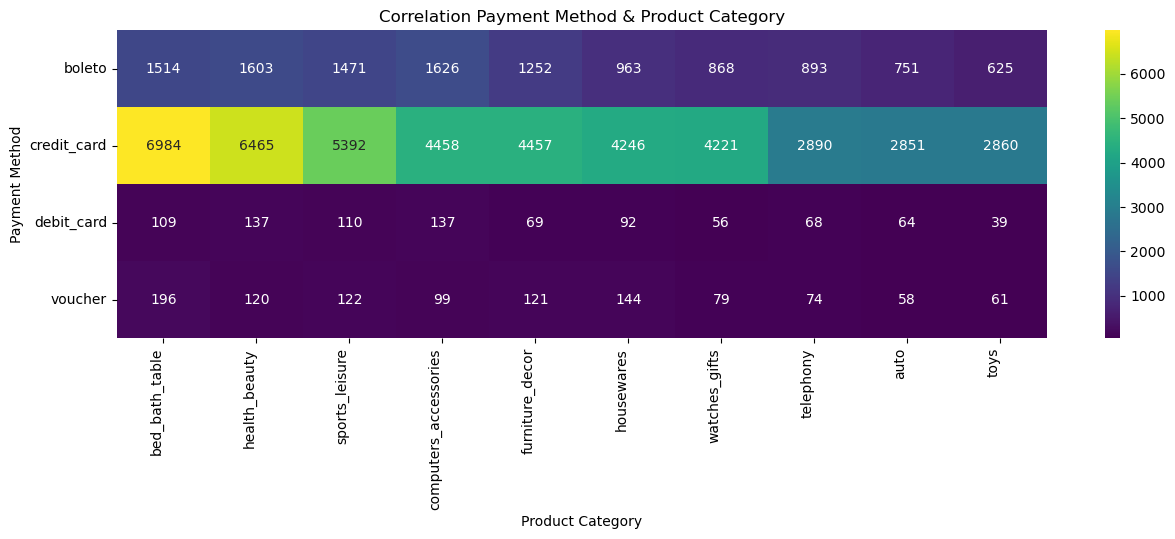

In [95]:
# Membuat crosstab untuk menghitung frekuensi kombinasi metode pembayaran dan kategori produk
payment_product_crosstab = pd.crosstab(populer_payment_method_and_product['payment_type'],
                                        populer_payment_method_and_product['product_category_name_english'])

# Mengambil 10 kategori produk terpopuler
top_10_categories = payment_product_crosstab.sum(axis=0).sort_values(ascending=False).head(10).index

# Memfilter crosstab untuk hanya menyertakan 10 kategori terpopuler
payment_product_crosstab_top10 = payment_product_crosstab[top_10_categories]

# Membuat heatmap
plt.figure(figsize=(15, 4))
sns.heatmap(payment_product_crosstab_top10, annot=True, cmap='viridis', fmt='d')  # Menambahkan anotasi dan format angka
plt.title('Correlation Payment Method & Product Category')
plt.xlabel('Product Category')
plt.ylabel('Payment Method')
plt.xticks(rotation=90, ha='right')  # Rotasi label sumbu x agar mudah dibaca
plt.yticks(rotation=0)  # Mengatur rotasi label sumbu y menjadi 0
plt.show()

- Visualisasi heatmap ini menunjukkan bahwa kartu kredit menjadi metode pembayaran yang paling dominan
- Kategori bed_bath_table adalah produk yang paling banyak dibeli
- Kemudian Boleto juga cukup populer pada beberapa kategori seperti computers_accessories. Sementara itu, kartu debit dan voucher menunjukkan jumlah transaksi yang relatif lebih rendah.
- Insight ini dapat membantu kita dalam mengoptimalkan strategi pembayaran dan menyesuaikan penawaran berdasarkan preferensi konsumen di setiap kategori produk."

### The most ordered categories each year and how are the categories developing each year

- Melihat top kategory produk yang paling sering di order setiap tahunnya.

In [79]:
# Menghitung jumlah pemesanan per kategori per tahun
category_trend = df.groupby(['year', 'product_category_name_english'])['order_id'].count().reset_index()
category_trend.rename(columns={'order_id': 'total_orders'}, inplace=True)

# Mendapatkan kategori produk yang paling banyak dipesan setiap tahun (top 5 per tahun)
top_categories_per_year = category_trend.sort_values(['year', 'total_orders'], ascending=[True, False]).groupby('year').head(5)

In [80]:
# Cek hasil
top_categories_per_year

,year,product_category_name_english,total_orders
16,2016,furniture_decor,76
18,2016,health_beauty,42
23,2016,perfumery,32
27,2016,toys,22
25,2016,sports_leisure,17
36,2017,bed_bath_table,5610
68,2017,furniture_decor,4268
94,2017,sports_leisure,4159
72,2017,health_beauty,3732
44,2017,computers_accessories,3135


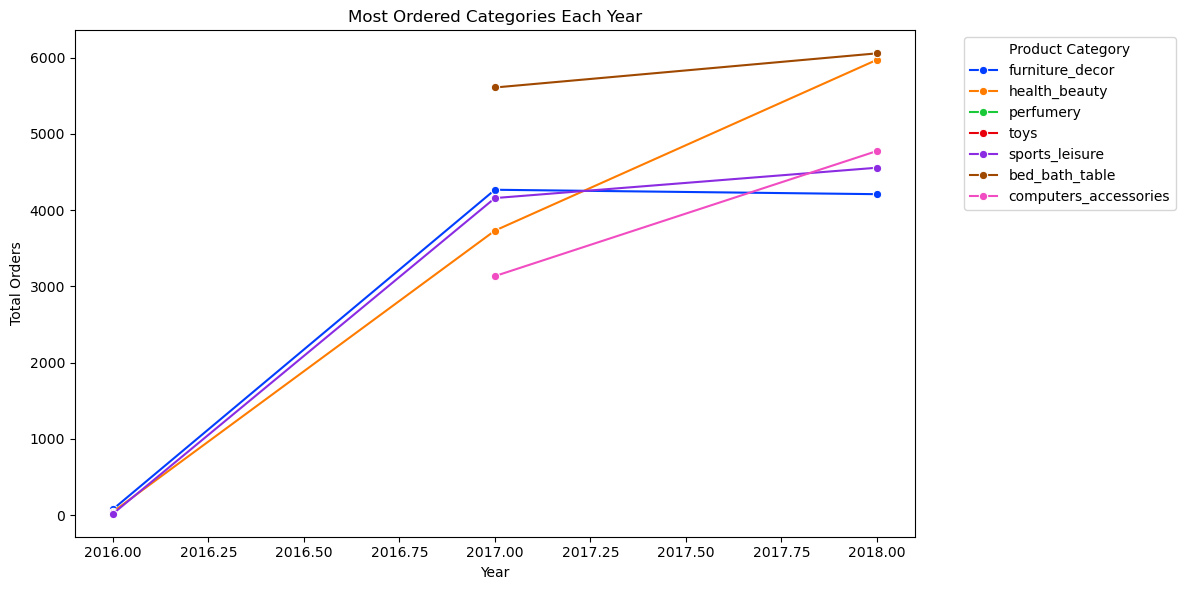

In [81]:
# Visualisasi perkembangan kategori per tahun
plt.figure(figsize=(12,6))
sns.lineplot(
    x='year',
    y='total_orders',
    hue='product_category_name_english',
    data=top_categories_per_year,
    marker='o',
    palette='bright'  # Ganti dengan 'husl' atau 'tab10' juga bisa
)
plt.xlabel("Year")
plt.ylabel("Total Orders")
plt.title("Most Ordered Categories Each Year")
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- Kemudian melihat lebih spesifik lagi Top produk 5 per bulan

C:\Users\W10\AppData\Local\Temp\ipykernel_10356\2793357012.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_per_month = product_monthly_sales.groupby('yearmonth').apply(


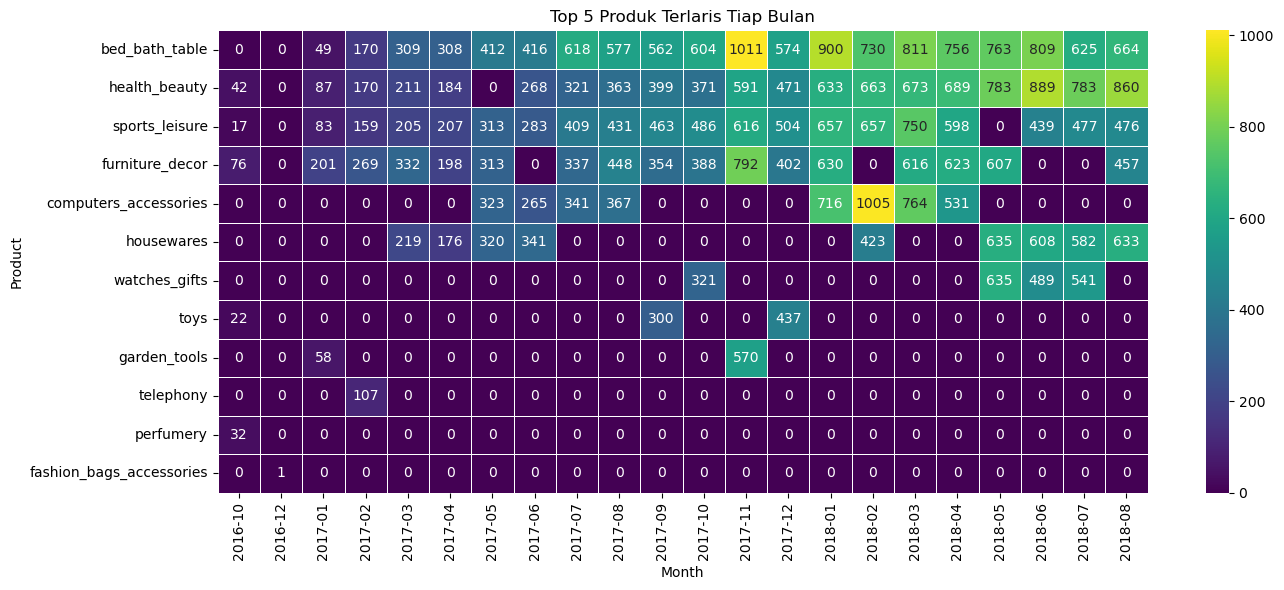

In [99]:
# Hitung total penjualan per produk per bulan (yearmonth)
product_monthly_sales = df.groupby(['yearmonth', 'product_category_name_english'])['order_item_id'].count().reset_index(name='total_sales')

# Untuk setiap bulan, ambil 5 produk terlaris
top5_per_month = product_monthly_sales.groupby('yearmonth').apply(
    lambda x: x.nlargest(5, 'total_sales')
).reset_index(drop=True)

# Pivot data untuk heatmap: index=product_id, columns=yearmonth, values=total_sales
heatmap_data = top5_per_month.pivot(index='product_category_name_english', columns='yearmonth', values='total_sales').fillna(0)

# Urutkan produk berdasarkan total penjualan keseluruhan agar heatmap lebih informatif
total_sales_per_product = heatmap_data.sum(axis=1).sort_values(ascending=False)
heatmap_data = heatmap_data.loc[total_sales_per_product.index]

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='viridis', linewidths=0.5)

plt.title('Top 5 Produk Terlaris Tiap Bulan')
plt.xlabel('Month')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

##  Kesimpulan

### 1. Most Ordered Categories Each Year (Line Plot)
- Tiga kategori dengan total pesanan tertinggi secara konsisten setiap tahun adalah:
  - `bed_bath_table`
  - `health_beauty`
  - `sports_leisure`
- Terjadi peningkatan signifikan jumlah pesanan dari tahun 2016 ke 2017.
- Pertumbuhan cenderung melambat pada 2018, terutama pada kategori seperti `furniture_decor` dan `health_beauty`.
- Kategori `computers_accessories` dan `perfumery` tetap berada di bawah kategori lainnya dalam jumlah pesanan.

### 2. Top 5 Produk Terlaris Tiap Bulan (Heatmap)
- Kategori `bed_bath_table`, `health_beauty`, dan `computers_accessories` mendominasi top 5 pada berbagai bulan dari 2017 hingga pertengahan 2018.
- Lonjakan penjualan signifikan terlihat pada:
  - `computers_accessories` di **Desember 2017** (1005 pesanan)
  - `bed_bath_table` di **November 2017** (1011 pesanan)
- Kategori seperti `garden_tools`, `toys`, dan `perfumery` muncul sesekali, menunjukkan pola musiman atau niche market.

---

## Suggestion/Recommendation

1. **Fokus pada Kategori Unggulan**
   - Prioritaskan stok dan promosi untuk `bed_bath_table`, `health_beauty`, dan `computers_accessories`, terutama menjelang akhir tahun.

2. **Strategi Pemasaran Musiman**
   - Maksimalkan penjualan kategori musiman seperti `toys` dan `garden_tools` dengan kampanye khusus menjelang hari libur atau musim tertentu.

3. **Analisis Mendalam pada Lonjakan Desember**
   - Tinjau ulang strategi marketing dan campaign yang dilakukan pada Desember 2017, terutama pada `computers_accessories`.

4. **Diversifikasi Kategori Kurang Populer**
   - Pertimbangkan bundling produk atau diskon menarik untuk kategori seperti `perfumery` dan `fashion_bags_accessories`.

5. **Optimasi Rantai Pasok (Supply Chain)**
   - Gunakan pola historis penjualan untuk mengatur logistik dan inventori agar lebih efisien, terutama untuk kategori dengan demand tinggi.

---



# Review Customer


- Memberikan informasi rata-rata skor ulasan untuk setiap customer, dengan asumsi bahwa skor 4 dan 5 dianggap 'satisfied', sedangkan skor di bawahnya dianggap 'not satisfied'.

In [82]:
# Menghitung rata-rata review score per customer
avg_review_per_customer = df.groupby('customer_unique_id')['review_score'].mean().reset_index()
avg_review_per_customer.rename(columns={'review_score': 'avg_review_score'}, inplace=True)

# Menambahkan kolom kepuasan pelanggan
avg_review_per_customer['satisfaction_level'] = avg_review_per_customer['avg_review_score'].apply(
    lambda x: 'Satisfied' if x >= 4 else 'Not Satisfied'
)

In [83]:
# Melihat hasil
avg_review_per_customer.head()

,customer_unique_id,avg_review_score,satisfaction_level
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,Satisfied
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,Satisfied
2,0000f46a3911fa3c0805444483337064,3.0,Not Satisfied
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,Satisfied
4,0004aac84e0df4da2b147fca70cf8255,5.0,Satisfied


In [84]:
# Klasifikasi kepuasan pelanggan
avg_review_per_customer['satisfaction_level'] = avg_review_per_customer['avg_review_score'].apply(lambda x: 'Satisfied' if x >= 4 else 'Not Satisfied')

# Hitung jumlah pelanggan dalam setiap kategori kepuasan
satisfaction_counts = avg_review_per_customer['satisfaction_level'].value_counts()

# Hitung persentase pelanggan yang puas dan tidak puas
satisfaction_percentage = (satisfaction_counts / satisfaction_counts.sum()) * 100

In [85]:
satisfaction_percentage

satisfaction_level
Satisfied        78.720217
Not Satisfied    21.279783
Name: count, dtype: float64

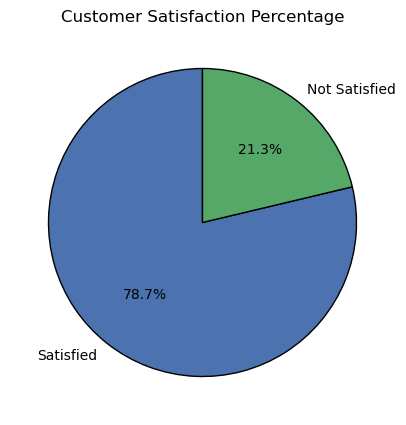

In [86]:
# Membuat pie chart untuk Customer Satisfaction Percentage
plt.figure(figsize=(8,5))
satisfaction_colors = ['#4c72b0', '#55a868']  # Biru dan Hijau 
satisfaction_percentage.plot(kind='pie', autopct='%1.1f%%', 
                             colors=satisfaction_colors, startangle=90, 
                             wedgeprops={'edgecolor': 'black'})
plt.ylabel("")
plt.title("Customer Satisfaction Percentage")
plt.show()

### Insight
- Mayoritas customer (78.7%) merasa puas dengan pengalaman belanja mereka, menunjukkan bahwa layanan yang diberikan oleh platform secara umum berhasil memenuhi harapan konsumen.

- Namun, masih terdapat 21.3% customer yang tidak puas, yang merupakan proporsi yang cukup signifikan dan perlu menjadi perhatian. 

### Menyajikan informasi skor ulasan dari masing-masing customer.
   - Pilih customer yang mengisi kolom judul dan pesan ulasan, lalu hitung total ulasan untuk setiap customer dan gabungkan dengan tabel total pesanan untuk mendapatkan rasio ulasan per transaksi.

In [87]:
total_reviews_per_customer = df.groupby('customer_unique_id')['review_score'].count().reset_index()
total_reviews_per_customer.rename(columns={'review_score': 'total_reviews'}, inplace=True)

In [88]:
total_reviews_per_customer

,customer_unique_id,total_reviews
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
91448,fffcf5a5ff07b0908bd4e2dbc735a684,2
91449,fffea47cd6d3cc0a88bd621562a9d061,1
91450,ffff371b4d645b6ecea244b27531430a,1
91451,ffff5962728ec6157033ef9805bacc48,1


In [89]:
# Memfilter data untuk memilih customer yang mengisi title dan message review
filtered_data = df[(df['review_comment_title'].notna()) & (df['review_comment_message'].notna())]

In [90]:
# Membuat tabel untuk menghitung total review untuk setiap customer
review_table = filtered_data.groupby('customer_id')['review_id'].count().reset_index()
review_table.columns = ['customer_id', 'total_reviews']

In [91]:
review_table

,customer_id,total_reviews
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
94454,fffcb937e9dd47a13f05ecb8290f4d3e,1
94455,fffecc9f79fd8c764f843e9951b11341,3
94456,fffeda5b6d849fbd39689bb92087f431,1
94457,ffff42319e9b2d713724ae527742af25,1


In [92]:
# Membuat tabel untuk menghitung total order untuk setiap customer
order_table = df.groupby('customer_id')['order_id'].nunique().reset_index()
order_table.columns = ['customer_id', 'total_orders']

In [93]:
order_table

,customer_id,total_orders
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
94454,fffcb937e9dd47a13f05ecb8290f4d3e,1
94455,fffecc9f79fd8c764f843e9951b11341,1
94456,fffeda5b6d849fbd39689bb92087f431,1
94457,ffff42319e9b2d713724ae527742af25,1


In [94]:
# Menggabungkan tabel review dan order
review_transaction_ratio_table = pd.merge(review_table, order_table, on='customer_id')

# Menghitung review ratio per transaction untuk setiap customer
review_transaction_ratio_table['review_ratio'] = review_transaction_ratio_table['total_reviews'] / review_transaction_ratio_table['total_orders']

In [95]:
# Melihat hasil
review_transaction_ratio_table

,customer_id,total_reviews,total_orders,review_ratio
0,00012a2ce6f8dcda20d059ce98491703,1,1,1.0
1,000161a058600d5901f007fab4c27140,1,1,1.0
2,0001fd6190edaaf884bcaf3d49edf079,1,1,1.0
3,0002414f95344307404f0ace7a26f1d5,1,1,1.0
4,000379cdec625522490c315e70c7a9fb,1,1,1.0
...,...,...,...,...
94454,fffcb937e9dd47a13f05ecb8290f4d3e,1,1,1.0
94455,fffecc9f79fd8c764f843e9951b11341,3,1,3.0
94456,fffeda5b6d849fbd39689bb92087f431,1,1,1.0
94457,ffff42319e9b2d713724ae527742af25,1,1,1.0


In [96]:
# Menampilkan distribusi nilai review_score
# ini akan menampilkan berapa banyak setiap nilai review_score muncul dalam dataset
df['review_score'].value_counts()

review_score
5    65139
4    21811
1    12861
3     9528
2     3839
Name: count, dtype: int64

In [97]:
# Melihat hasil
total_reviews_per_customer.head()

,customer_unique_id,total_reviews
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


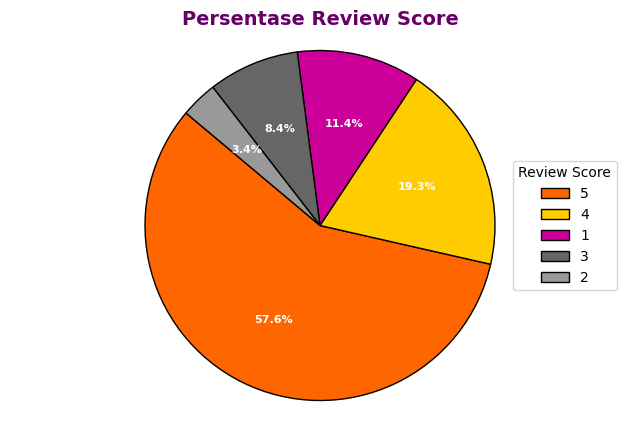

In [98]:
# Menghitung distribusi review_score dalam persen
review_counts = df['review_score'].value_counts()
review_percent = (review_counts / review_counts.sum()) * 100

# Warna sesuai dengan contoh gambar
colors = ['#ff6600', '#ffcc00', '#cc0099', '#666666', '#999999']

# Membuat pie chart
fig, ax = plt.subplots(figsize=(8, 5))
wedges, texts, autotexts = ax.pie(
    review_percent, labels=review_percent.index, autopct='%1.1f%%',
    colors=colors[:len(review_percent)], startangle=140, wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 8, 'color': 'white', 'weight': 'bold'}
)

# Menambahkan legenda di sisi kanan
ax.legend(wedges, review_percent.index, title="Review Score", loc="center left", bbox_to_anchor=(0.8, 0.5))

# Menambahkan judul dengan warna dan gaya seperti contoh
plt.title('Persentase Review Score', fontsize=14, fontweight='bold', color='#660066')
plt.axis('equal')  # Menjaga aspek ratio lingkaran
plt.show()

### Insight
Analisis kepuasan pelanggan kami menunjukkan hasil yang sangat positif. Sebagian besar customer, yakni 57,6%, memberikan penilaian tertinggi dengan skor 5 (sangat puas). Sementara itu, 19,3% customer memberikan nilai 4, dan 11,4% memberikan nilai 1. Kategori penilaian menengah yaitu skor 3 dan 2 masing-masing mendapat persentase yang lebih kecil, sebesar 8,4% dan 3,4%. Data ini mengindikasikan bahwa mayoritas pelanggan kita sangat puas dengan produk/layanan yang diberikan, meskipun masih ada ruang perbaikan untuk mengurangi persentase pelanggan yang memberikan nilai rendah.

---

### Suggestion/Recommendation
- Analisis ulasan buruk untuk deteksi masalah produk/penjual.
- Tingkatkan kontrol kualitas & layanan customer.


# Time Series Analysis

- Analisis Pola Penjualan per Hari 

In [99]:
# Menghitung total penjualan per hari
daily_sales = df.groupby(df['order_purchase_timestamp'].dt.date)['price'].sum().reset_index()
daily_sales.rename(columns={'order_purchase_timestamp': 'date', 'price': 'total_sales'}, inplace=True)

In [100]:
daily_sales

,date,total_sales
0,2016-10-03,441.98
1,2016-10-04,9093.20
2,2016-10-05,6329.57
3,2016-10-06,5889.96
4,2016-10-07,5955.35
...,...,...
606,2018-08-25,10711.93
607,2018-08-26,8235.71
608,2018-08-27,4825.87
609,2018-08-28,3757.51


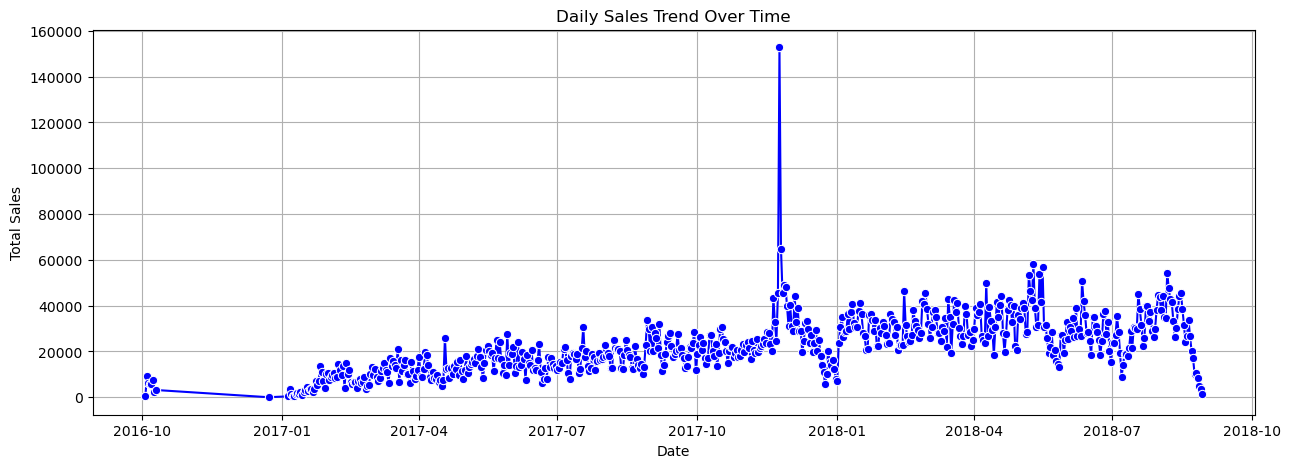

In [101]:
# Konversi kolom date ke format datetime
daily_sales['date'] = pd.to_datetime(daily_sales['date'])

# Visualisasi tren penjualan harian
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='total_sales', data=daily_sales, marker='o', color='b')
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Daily Sales Trend Over Time")
plt.grid(True)
plt.show()

Karena cukup fluaktatif maka saya analisis per bulan saja agar lebih mudah melihat tren penjualannya

In [ ]:
# Menghitung total penjualan per bulan
monthly_sales = df.groupby('yearmonth')['price'].sum().reset_index()
monthly_sales.rename(columns={'price': 'total_sales'}, inplace=True)

# Buat yearmonth dalam format datetime:
monthly_sales['yearmonth'] = pd.to_datetime(monthly_sales['yearmonth'])

In [108]:
monthly_sales

,yearmonth,total_sales
0,2016-10-01,41043.73
1,2016-12-01,10.90
2,2017-01-01,116505.92
3,2017-02-01,234576.40
4,2017-03-01,370039.64
5,2017-04-01,349595.61
6,2017-05-01,516091.99
7,2017-06-01,437773.82
8,2017-07-01,510081.68
9,2017-08-01,572738.71


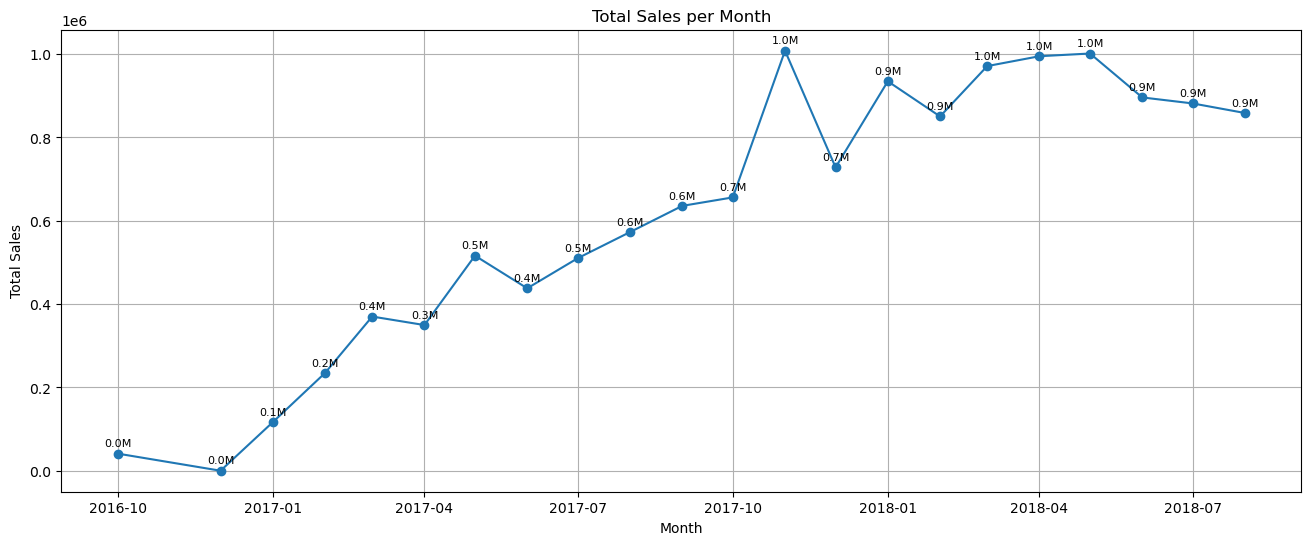

In [114]:
# Visualisasi
plt.figure(figsize=(16,6))
plt.plot(monthly_sales['yearmonth'], monthly_sales['total_sales'], marker='o')
plt.title('Total Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
# Tambahkan angka di tiap titik
for i, txt in enumerate(monthly_sales['total_sales']):
    plt.annotate(f'{txt/1e6:.1f}M', (monthly_sales['yearmonth'][i], monthly_sales['total_sales'][i]),
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='black')

plt.show()

### Insight
Tren penjualan secara keseluruhan menunjukkan peningkatan selama periode tersebut, dengan puncak signifikan terjadi pada November 2017, yang merupakan bagian dari musim kampanye penjualan di kuartal keempat (Q4 2017).

---

### Suggestion/Recommendation
- Fokuskan kampanye besar pada Q4 (Oktober–Desember), terutama di bulan November, yang terbukti menjadi puncak penjualan. 
- Buat kampanye khusus seperti pre-sale November, promo 11.11, atau bundling akhir tahun.
- Untuk kampanye produk Pada momen ini fokuskan pada kategori Top 5 produk di bulan November.

- Tren Musiman Harian Berdasarkan Hari dalam Seminggu

In [103]:
# Menghitung total order per hari dalam seminggu
weekday_sales = df.groupby('day')['order_id'].count().reset_index()
weekday_sales.rename(columns={'order_id': 'total_orders'}, inplace=True)

# Menyusun hari agar urut dari Senin - Minggu
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales['day'] = pd.Categorical(weekday_sales['day'], categories=order_days, ordered=True)
weekday_sales = weekday_sales.sort_values('day')

In [104]:
weekday_sales

,day,total_orders
1,Monday,18365
5,Tuesday,18404
6,Wednesday,17671
4,Thursday,16906
0,Friday,16184
2,Saturday,12202
3,Sunday,13446


C:\Users\W10\AppData\Local\Temp\ipykernel_5924\3778030741.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='day', y='total_orders', data=weekday_sales, palette='coolwarm')


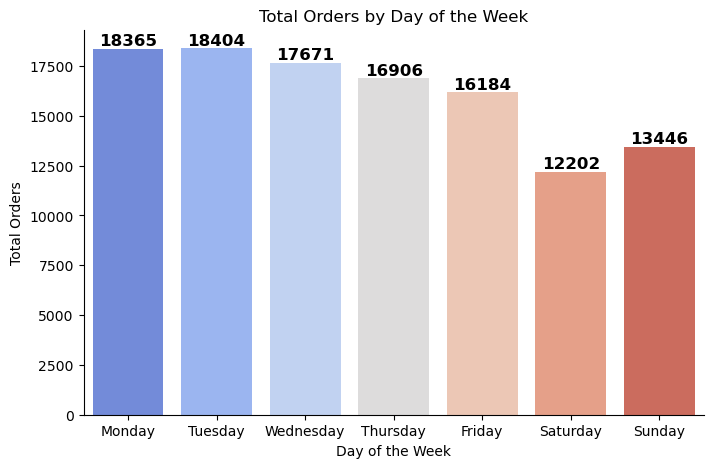

In [105]:
# Membuat figure
plt.figure(figsize=(8, 5))

# Membuat barplot
ax = sns.barplot(x='day', y='total_orders', data=weekday_sales, palette='coolwarm')

# Menambahkan angka di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Menghilangkan garis belakang (spines)
sns.despine()

# Menambahkan label dan judul
plt.xlabel("Day of the Week")
plt.ylabel("Total Orders")
plt.title("Total Orders by Day of the Week")

# Menampilkan plot
plt.show()


### Insight 
Grafik ini menunjukkan jumlah total pesanan berdasarkan hari dalam seminggu. Terlihat bahwa pemesanan cenderung lebih tinggi pada hari Senin hingga Rabu, dan mulai menurun pada akhir pekan, dengan jumlah pesanan terendah terjadi pada hari Sabtu.


# Kesimpulan Analisis Data OLIST

## 1. Customer Demografi
- Mayoritas customer berasal dari kota besar seperti **Sao Paulo** dan **Rio de Janeiro**.
- Persebaran customer **belum merata secara geografis**.

## 2. Perilaku Pemesanan
- Sebagian besar customer hanya belanja 1 kali atau single order. 
- Transaksi customer paling sibuk pada jam 10:00-16:00 pada weekday. Hari Sabtu penjualan terendah dan stabil sepanjang hari. Sedangkan hari Minggu customer mulai banyak transaksi pada jam 18:00–22:00 malam. 
- Secara keseluruhan tren menunjukkan peningkatan mencerminkan adanya pertumbuhan customer, dan puncak di Q4 terutama signifikan di November 2017.

## 3. Produk & Harga 
- Kategori produk yang mengalami pertumbuhan tahunan:
  - `bad_bath_table`
  - `health_beauty`
  - `furniture_decor`
- Produk **dengan harga murah lebih laris**, menunjukkan bahwa customer kecenderungan belanja produk lebih terjangkau.

## 4. Metode Pembayaran
- **Kartu kredit** adalah metode pembayaran paling populer.
- Menunjukkan preferensi customer terhadap **transaksi cepat dan fleksibel**.

## 5. Kualitas Produk & Layanan
- Mayoritas customer Satisfaction 78.7% dan skor 4-5 sekitar 76.9% dengan produk dan layanan yang diberikan
- Persentase customer yang Not Satisfied 21.3% dan Review Score yang rendah skor 1-2 sekitar 14.8%.

---

# Rekomendasi Bisnis

## Retensi Customer
- Pancing Repeat Order ke customer single order, seperti kirim email promo personalisasi.
- Buat program loyalitas/reward untuk customer aktif.
## Prioritas Target Pasar
- Fokus ke wilayah Sao Paulo dan Rio de Janeiro yang banyak customer.
## Optimalisasi Momen Musiman
- Fokuskan kampanye besar pada Q4 (Oktober–Desember), terutama di bulan November, yang terbukti menjadi puncak penjualan. 
- Buat kampanye khusus seperti pre-sale November, promo 11.11, atau bundling akhir tahun.
- Untuk kampanye produk Pada momen ini fokuskan pada kategori Top 5 produk di bulan November.
## Segmentasi Harga
- Terapkan strategi upselling produk kategori Cheap ke produk kategori lebih tinggi.
- Kategori Normal dan Expensive memiliki nilai transaksi rata-rata lebih tinggi, dorong penjualannya melalui promosi dan bundling.
## Operasional & Pembayaran
- Jam/hari sibuk: Buat kampanye iklan, diskon, flash sale, dan push notification pada weekday, jam 10:00–16:00 dan jam 18:00-22:00 pada hari Minggu untuk meningkatkan urgensi pembelian.
- Hari dan Jam Sepi : Terapkan promosi berbeda untuk mendorong pembelian di waktu yang kurang optimal.
- Sediakan beragam metode pembayaran.
## Evaluasi Layanan / Produk
- Analisis ulasan buruk untuk deteksi masalah produk/penjual.
- Tingkatkan kontrol kualitas & layanan pelanggan.

---
